In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import pickle
import math
import optuna
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import preprocessing
from NFLUtils import NFLUtils
nfl_utils = NFLUtils()

%matplotlib inline

# ANN
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# XGBoost 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns # confusion matrix

# Set device to GPU if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load CSV & UMAP model
cp Combined.csv ~/drive/Notes/ML/Pytorch/footballData/

In [3]:
# Load CSV
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)

df.info()

# The performance set's size is defined in the SlidingWindowNFL-1 file. When kick_punt_umap_dim_1 (or 2) is blank
test_performance_df = df[df['kick_punt_umap_dim_1'].isna()]
df = df[df['kick_punt_umap_dim_1'].isna() == False]
print(f'df after perf set removed: {df.shape}')
print(f'performance set size: {test_performance_df.shape}')

# Remove missing odds data (Ignore data with no odds?)
test_performance_df = test_performance_df[test_performance_df['D_start_odds'] != 0.0]

print(f'df after missing odds removed: {df.shape}')
print(f'df perf after missing odds removed: {test_performance_df.shape}')

# Load the UMAP
filename = "kick_punt_umap.sav"
umap_model = None
try:
    with open(filename, 'rb') as file:
        umap_model = pickle.load(file)
        print(type(umap_model))
except EOFError:
    print("The file is empty or corrupt. Please check its content.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5505 entries, 0 to 5504
Columns: 196 entries, Unnamed: 0 to kick_punt_umap_dim_2
dtypes: float64(179), int64(14), object(3)
memory usage: 8.2+ MB
df after perf set removed: (5305, 196)
performance set size: (200, 196)
df after missing odds removed: (5305, 196)
df perf after missing odds removed: (188, 196)
<class 'umap.umap_.UMAP'>


### Remove items w/ missing odds data, apply UMAP to performance set

In [4]:
# Remove missing odds data
test_performance_df = test_performance_df[test_performance_df['D_start_odds'] != 0.0]
print(test_performance_df.shape)

# ---- Apply UMAP to performance set ----
# Fit standardScaler on the training set
umap_columns = ["D_kick_punt_returns_lng", "D_kick_punt_returns_rt", "D_kick_punt_returns_yds"]
umap_train_df = df[umap_columns]
umap_scaler = StandardScaler().fit(umap_train_df)

# Scale the test set
scaled_return_game_df = umap_scaler.transform(test_performance_df[umap_columns])

if umap_model is None:
    print("UMAP not correctly loaded FIX NOW")

umap_embedding = umap_model.transform(scaled_return_game_df)
print(umap_embedding.shape)

# Create the two new columns, drop the 4
test_performance_df['kick_punt_umap_dim_1'] = umap_embedding[:,0]
test_performance_df['kick_punt_umap_dim_2'] = umap_embedding[:,1]

test_performance_df.drop(umap_columns, axis=1, inplace=True)
df.drop(umap_columns, axis=1, inplace=True)



(188, 196)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(188, 2)


In [9]:
test_performance_df[:5]
# print(test_performance_df['H_start_odds'][:5])
# print(test_performance_df['V_start_odds'][:5])

,Unnamed: 0,Season,Date,Home_Team,H_Q1,H_Q2,H_Q3,H_Q4,H_OT,H_Final,Visitor_Team,V_Q1,V_Q2,V_Q3,V_Q4,V_OT,V_Final,H_First_Downs,V_First_Downs,H_Rush,V_Rush,H_Yds,V_Yds,H_TDs,V_TDs,H_Cmp,V_Cmp,H_Att,V_Att,H_Yd,V_Yd,H_TD,V_TD,H_INT,V_INT,H_Sacked,V_Sacked,H_Sacked_Yards,V_Sacked_Yards,H_Net_Pass_Yards,V_Net_Pass_Yards,H_Total_Yards,V_Total_Yards,H_Fumbles,V_Fumbles,H_Lost,V_Lost,H_Turnovers,V_Turnovers,H_Penalties,V_Penalties,H_Penalties_Yards,V_Penalties_Yards,H_Third_Down_Conv,V_Third_Down_Conv,H_Fourth_Down_Conv,V_Fourth_Down_Conv,H_Time_of_Possession,V_Time_of_Possession,H_passing_att,H_passing_cmp,H_passing_int,H_passing_lng,H_passing_sk,H_passing_td,H_receiving_lng,H_rushing_att,H_rushing_lng,H_rushing_td,H_rushing_yds,V_passing_att,V_passing_cmp,V_passing_int,V_passing_lng,V_passing_sk,V_passing_td,V_receiving_lng,V_rushing_att,V_rushing_lng,V_rushing_td,V_rushing_yds,H_def_interceptions_int,H_def_interceptions_td,H_def_interceptions_yds,H_fumbles_ff,H_fumbles_fr,H_fumbles_td,H_fumbles_yds,H_sk,H_tackles_ast,H_tackles_comb,H_tackles_solo,V_def_interceptions_int,V_def_interceptions_td,V_def_interceptions_yds,V_fumbles_ff,V_fumbles_fr,V_fumbles_td,V_fumbles_yds,V_sk,V_tackles_ast,V_tackles_comb,V_tackles_solo,H_punting_pnt,H_scoring_fga,H_scoring_xpa,V_punting_pnt,V_scoring_fga,V_scoring_xpa,H_halftime_odds,V_halftime_odds,H_start_odds,V_start_odds,H_Won,H_passing_rushing_td,V_passing_rushing_td,H_Final_Allowed,V_Final_Allowed,H_kick_punt_returns_lng,H_kick_punt_returns_rt,H_kick_punt_returns_td,H_kick_punt_returns_yds,H_scoring_fgp,H_scoring_xpp,H_punting_avg,V_kick_punt_returns_lng,V_kick_punt_returns_rt,V_kick_punt_returns_td,V_kick_punt_returns_yds,V_scoring_fgp,V_scoring_xpp,V_punting_avg,H_pythagorean,V_pythagorean,H_datediff,V_datediff,D_First_Downs,D_Rush,D_Yds,D_TDs,D_Cmp,D_Att,D_Yd,D_TD,D_INT,D_Sacked,D_Sacked_Yards,D_Net_Pass_Yards,D_Total_Yards,D_Fumbles,D_Lost,D_Turnovers,D_Penalties,D_Third_Down_Conv,D_Fourth_Down_Conv,D_Time_of_Possession,D_passing_att,D_passing_cmp,D_passing_int,D_passing_lng,D_passing_sk,D_passing_td,D_receiving_lng,D_rushing_att,D_rushing_lng,D_rushing_td,D_rushing_yds,D_passing_rushing_td,D_def_interceptions_int,D_def_interceptions_td,D_def_interceptions_yds,D_fumbles_ff,D_fumbles_fr,D_fumbles_td,D_fumbles_yds,D_sk,D_tackles_ast,D_tackles_comb,D_tackles_solo,D_punting_pnt,D_punting_avg,D_scoring_fga,D_scoring_fgp,D_scoring_xpa,D_scoring_xpp,D_Final,D_Final_Allowed,D_start_odds,D_halftime_odds,D_datediff,D_pythagorean,kick_punt_umap_dim_1,kick_punt_umap_dim_2
5305,7645,2023,2024-02-11,SFO,0,10,0,9,3,26.327756,KAN,0,3,10,6,6,23.565749,21.681889,20.03471,85.286041,53.241765,16.837382,12.335741,37.022830,94.260273,27.544142,24.595582,86.247511,122.984985,13.874851,9.667066,185.654186,127.621534,0.909679,0.553025,6.131457,7.571339,10.101820,2.341893,248.115479,222.061301,383.994236,355.447188,0.294323,1.014176,0.790133,1.558539,0.961939,1.105717,14.763529,20.107144,6,55,52.691158,30.340287,29.509262,50.474282,30.114245,27.015743,32.249467,20.685092,0.681074,47.279149,1.911462,1.682720,126.607746,27.457345,53.970660,1.610792,135.878758,31.169328,19.743665,0.297006,39.073186,0.692465,1.333246,118.436566,26.637019,59.475233,0.735864,133.385887,1.405798,0.079550,15.406524,0.595246,0.497786,0.000000,0.510743,1.844116,19.448767,60.306976,40.858210,0.296697,0.000,0.60054,1.163285,1.28807,0.146419,14.120897,1.788186,24.397286,69.009875,44.612589,3.068265,1.364111,3.373062,2.562885,2.77236,2.204331,1.301111,3.472222,1.757009,2.028809,0.0,3.293512,2.06911,20.177794,17.018386,28.075001,2.839997,0.000000,42.038545,0.560247,0.937146,46.622098,22.023097,2.8641,0.0,39.796869,0.935373,0.998549,47.624768,0.756792,0.652535,14.0,14.0,1.647,32.044,4.502,-57.237,2.949,-36.737,4.208,58.033,0.357,-1.440,7.760,26.054,28.547,-0.720,-0.768,-0.144,-5.344,22.351,-20.965,3.099,1.080,0.941,0.384,8.206,1.219,0.349,8.171,0.820,-5.505,0.875,2.493,1.224,1.109,0.080,14.806,-0.568,-0.790,-0.146,-13.610,0.056,-4.949,-8.703,-3.754,

# Columns to use
(TODO)

## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [10]:
cat_cols = []

cont_cols = [col for col in nfl_utils.cont_cols if col not in nfl_utils.drop_cols]


y_col = ['H_Won'] # Old
y_col = ['H_Won', 'H_start_odds', 'V_start_odds']
y_col_perf = ['H_Won', 'H_start_odds', 'V_start_odds', 'H_halftime_odds', 'V_halftime_odds']


# create cont_df and y_df from the df
print(df.shape)
cont_df = df[cont_cols]
y_df = df[y_col]

# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col_perf]
perf_date_df = test_performance_df[['Date','Home_Team', 'Visitor_Team']]

# print(cont_df.dtypes)
print(cont_df.shape)
print(perf_y_df.shape)
print(perf_y_df.tail())
# print(perf_conts_df.tail())


(5305, 193)
(5305, 48)
(188, 5)
      H_Won  H_start_odds  V_start_odds  H_halftime_odds  V_halftime_odds
5500    0.0      1.724771      2.073398              0.0              0.0
5501    0.0      4.991514      1.159063              0.0              0.0
5502    1.0      4.513858      1.188369              0.0              0.0
5503    0.0      3.804017      1.250000              0.0              0.0
5504    0.0      1.790476      1.986097              0.0              0.0


In [11]:
perf_y_df[:5]

,H_Won,H_start_odds,V_start_odds,H_halftime_odds,V_halftime_odds
5305,0.0,1.757009,2.028809,1.301111,3.472222
5306,1.0,1.461897,2.642566,1.056667,9.383333
5307,0.0,1.790476,1.986097,4.491667,1.198333
5308,0.0,3.043214,1.362319,12.958333,1.033333
5309,1.0,1.428571,2.758468,1.236667,4.008333


#### 1a. Normalize cont_df
StandardScaler is instead used by the pipeline

In [8]:
# min_max_scaler = preprocessing.MinMaxScaler()
# cont_scaled = min_max_scaler.fit_transform(cont_df.values)
# cont_df = pd.DataFrame(cont_scaled)
# cont_df.head()

# # test performance set
# perf_conts_df_scaled = min_max_scaler.fit_transform(perf_conts_df.values)
# perf_conts_df = pd.DataFrame(perf_conts_df_scaled)

### 3. Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [9]:
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)
perf_date_col = np.stack([perf_date_df[col].values for col in list(perf_date_df.columns)], 1)


conts_train = conts
y_train = y_col

### 4. Convert conts to tensor

In [10]:
print(conts.shape)
print(y_col.shape)

(5108, 48)
(5108, 1)


In [11]:
# Handled by model.fit()
# conts = torch.tensor(conts, dtype=torch.float32)
# y_col = torch.tensor(y_col, dtype=torch.float32)

In [ ]:
class TabularModelUpdated(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, criterion=nn.MSELoss(),
                optimizer_class=torch.optim.Adam, lr=0.001, confidence_threshold=0.1):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr
        
        # Training params
        self.criterion = criterion
        self.confidence_threshold = confidence_threshold
        
        # BatchNorm layer for continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),  # Mish instead of ReLU
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([
            nn.Linear(self.layer_shape[-1], out_sz),
            # nn.Sigmoid()  # Ensures output between 0 and 1
        ])
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        # Initialize the optimizer
        self.optimizer = optimizer_class(self.parameters(), lr=self.lr)

        
    def forward(self, x_cont):
        x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return x
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
        
        # Initialize optimizer
        # optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        # Training loop
        self.train()
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return self
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas > 0.5).astype(int)
        # return probas
    
    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)
            return self(X).numpy()

    def score(self, X, y):
        """
        Custom eval metric aiming to:
            1. Apply kelly criterion to size bet with prediction confidence & ignore certain predictions
            2. Penalize predictions that lie too close to the market's prediction (via pearson's correlation)
            
        """
        # Get prediction (0-1 where < 0.5 = visitor predicted win, otherwise home predicted win)
        # convert this into prediciton probability
        probas = self.predict_proba(X)
        prediction_h_won = np.where(probas < 0.5, 0, 1)
        x_won_probability = np.where(probas < 0.5, probas * 2, probas)

        # Convert decimal odds to probabilities, get odds for y based on winning team
        home_probs = 1 / np.array(y['H_start_odds'])
        visitor_probs = 1 / np.array(y['V_start_odds'])
        y_won_market_decimal_odds = np.where(y['H_Won'] == 1, y['H_start_odds'], y['V_start_odds'])
        
        # TODO: This needs a better name (from prediction, not y col)
        predicted_y_won_probability = np.where(prediction_h_won == 1, home_probs, visitor_probs)


        # 2. Kelly criterion (xwp is percent, y_won_market_odds is decimal)
        bankroll_fraction = x_won_probability - ((1 - x_won_probability) / y_won_market_decimal_odds)
        # 2a. Apply mask to filter out when kelly returns <= 0
        mask = (bankroll_fraction > 0)
        valid_mask = np.where(mask, bankroll_fraction, np.nan)
        ~np.isnan(x_won_probability)
        
        # 2. Pearson correlation coefficient based on the model's predicted winner. 0 to 1
        pearson_coefficient = np.absolute(r_regression(x_won_probability, predicted_y_won_probability))

    
    
        
    def old_score(self, X, y):
        """
        12/5 - this isn't called at all if 'scoring' is defined
        """
        probas = self.predict_proba(X)
        # First apply confidence thresholding
        mask = (probas < 0.5 - self.confidence_threshold) | (probas > 0.5 + self.confidence_threshold)
        predictions = np.where(mask, (probas > 0.5).astype(np.int32), np.nan)

        # Use numpy mask for nan values
        valid_mask = ~np.isnan(predictions)
        valid_predictions = predictions[valid_mask]
        valid_targets = y[valid_mask]
        
        # Penalize if < 80% predicted
        if (1.0* len(valid_predictions) / len(X)) < 0.85:
            # print(f"mask {len(valid_predictions)}  pred {len(X)}")
            return 0.0

        # Apply f1 score
        score = f1_score(valid_predictions.flatten(), valid_targets)
        return score

In [17]:
def objective(trial):
    # --- Suggest hyperparameters ---

    criterion = trial.suggest_categorical('criterion', nfl_utils.map_losses(None).keys())
    first_layer_size = trial.suggest_categorical('first_layer_size', [64, 56, 48, 32, 16, 12])
    min_layers = math.floor(math.sqrt(first_layer_size))
    num_layers = trial.suggest_int('num_layers', 2, min_layers)
    confidence_threshold = trial.suggest_float('confidence_threshold', 0, 0.05)
    layer_shape = [first_layer_size]
    for i in range(1, num_layers):
        layer_shape.append(first_layer_size//(2*i))
    
    # Set random state to have consistent results (42 is arbitrary)
    set_all_seeds()
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=False)

    # Split once
    X_train_fold = []
    X_val = []
    y_train_fold = []
    y_val = []
    models = []
    for train_index, val_index in kf.split(conts_train):
        # print(f"train {train_index.shape} val {val_index.shape}")
        X_train_fold.append(torch.FloatTensor(conts_train[train_index]).to(device))
        X_val.append(torch.FloatTensor(conts_train[val_index]).to(device))

        y_train_fold.append(torch.FloatTensor(y_train[train_index]).to(device))
        y_val.append(torch.FloatTensor(y_train[val_index]).to(device))

        model = TabularModelUpdated(
            n_cont=conts.shape[1],
            out_sz=1,
            layer_shape=layer_shape,
            p=trial.suggest_float('dropout', 0.28, 0.38),     # Dropout
            criterion=nfl_utils.map_losses(criterion),
            optimizer_class=torch.optim.Adam,
            lr=trial.suggest_float('lr', 1e-3, 1e-2, log=True),   # Learning rate 
            confidence_threshold=confidence_threshold
        )
        pipeline = Pipeline([
            ('scaler', StandardScaler()), # Standardize the numerical features
            # ('regressor', LinearRegression()), # Apply a regression model
            ('model', model)
        ])
        models.append(pipeline)

    # Run once on each split, track average loss, stop if > max patience
    max_patience = 10
    current_patience = max_patience
    tracked_loss = 0.0
    n_epochs = 0
    while current_patience > 0 or n_epochs < 100:
        n_epochs = n_epochs + 1
        running_loss = []
        for i in range(0,n_splits):
            # ----- Train -----
            models[i].fit(X_train_fold[i], y_train_fold[i])

            # ----- Eval -----
            running_loss.append(models[i].score(X_val[i], y_val[i]))
            # y_pred = models[i].predict(X_val[i])
            # running_loss.append(f1_score(y_val[i], y_pred))
        running_loss = np.mean(running_loss)

        # ----- Current epoch loss > previous -----
        # print(f"{tracked_loss} {running_loss} {tracked_loss < running_loss}")
        if tracked_loss < running_loss:
            current_patience = max_patience
            tracked_loss = running_loss
        else:
            current_patience = current_patience - 1
    trial.suggest_int('n_epochs', n_epochs, n_epochs)
    trial.report(tracked_loss, n_epochs)
    return tracked_loss

def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")

In [18]:
study = optuna.create_study(
    direction='maximize',   # max because using f1
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=1000
    )
)
# Uncomment to run
if True:
    study.optimize(objective, n_trials=2000, callbacks=[print_callback])
    # study.optimize(objective, n_trials=3)
    print("Best trial:")
    trial = study.best_trial
    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2025-03-02 20:11:20,641] A new study created in memory with name: no-name-571f9f4a-ad10-43d4-941e-6072fa33018e
[I 2025-03-02 20:11:33,575] Trial 0 finished with value: 0.44086642419114536 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 2, 'confidence_threshold': 0.012538014874680786, 'dropout': 0.28124651361101594, 'lr': 0.004233958635390632, 'n_epochs': 144}. Best is trial 0 with value: 0.44086642419114536.


Trial 0 finished with value: 0.44086642419114536
Best trial so far: 0, value: 0.44086642419114536


[I 2025-03-02 20:11:49,850] Trial 1 finished with value: 0.14669276878833026 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.0402354807109669, 'dropout': 0.3748113362797768, 'lr': 0.0018748937719715632, 'n_epochs': 108}. Best is trial 0 with value: 0.44086642419114536.


Trial 1 finished with value: 0.14669276878833026
Best trial so far: 0, value: 0.44086642419114536


[I 2025-03-02 20:12:22,688] Trial 2 finished with value: 0.17864277704927434 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04123791171255932, 'dropout': 0.3221050103964721, 'lr': 0.003924833837605191, 'n_epochs': 131}. Best is trial 0 with value: 0.44086642419114536.


Trial 2 finished with value: 0.17864277704927434
Best trial so far: 0, value: 0.44086642419114536


[I 2025-03-02 20:12:40,339] Trial 3 finished with value: 0.22906006472038715 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.03810276610838044, 'dropout': 0.3585456768690177, 'lr': 0.006600846965325849, 'n_epochs': 133}. Best is trial 0 with value: 0.44086642419114536.


Trial 3 finished with value: 0.22906006472038715
Best trial so far: 0, value: 0.44086642419114536


[I 2025-03-02 20:13:10,403] Trial 4 finished with value: 0.4492335162014676 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0025920919147729374, 'dropout': 0.3088799598507141, 'lr': 0.0030265919539351795, 'n_epochs': 256}. Best is trial 4 with value: 0.4492335162014676.


Trial 4 finished with value: 0.4492335162014676
Best trial so far: 4, value: 0.4492335162014676


[I 2025-03-02 20:13:45,950] Trial 5 finished with value: 0.43584034412043104 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 3, 'confidence_threshold': 0.02659145387043349, 'dropout': 0.3622484468189097, 'lr': 0.002361676164249358, 'n_epochs': 238}. Best is trial 4 with value: 0.4492335162014676.


Trial 5 finished with value: 0.43584034412043104
Best trial so far: 4, value: 0.4492335162014676


[I 2025-03-02 20:14:30,688] Trial 6 finished with value: 0.20206051681068407 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.015489217519997428, 'dropout': 0.3682104422113942, 'lr': 0.008159296745660707, 'n_epochs': 137}. Best is trial 4 with value: 0.4492335162014676.


Trial 6 finished with value: 0.20206051681068407
Best trial so far: 4, value: 0.4492335162014676


[I 2025-03-02 20:14:57,115] Trial 7 finished with value: 0.18094098833563277 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.008388736052134955, 'dropout': 0.31406710975316576, 'lr': 0.0029815289553363133, 'n_epochs': 100}. Best is trial 4 with value: 0.4492335162014676.


Trial 7 finished with value: 0.18094098833563277
Best trial so far: 4, value: 0.4492335162014676


[I 2025-03-02 20:15:07,057] Trial 8 finished with value: 0.05656938904052069 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.048330660624766125, 'dropout': 0.28509119273693345, 'lr': 0.005255791665106613, 'n_epochs': 100}. Best is trial 4 with value: 0.4492335162014676.


Trial 8 finished with value: 0.05656938904052069
Best trial so far: 4, value: 0.4492335162014676


[I 2025-03-02 20:15:23,179] Trial 9 finished with value: 0.20192440578833049 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 56, 'num_layers': 2, 'confidence_threshold': 0.03871469735025729, 'dropout': 0.2833729436135273, 'lr': 0.0015769117514595574, 'n_epochs': 100}. Best is trial 4 with value: 0.4492335162014676.


Trial 9 finished with value: 0.20192440578833049
Best trial so far: 4, value: 0.4492335162014676


[I 2025-03-02 20:15:32,680] Trial 10 finished with value: 0.1835349957607309 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0018203422027876504, 'dropout': 0.34135964645827477, 'lr': 0.0010405980040501153, 'n_epochs': 100}. Best is trial 4 with value: 0.4492335162014676.


Trial 10 finished with value: 0.1835349957607309
Best trial so far: 4, value: 0.4492335162014676


[I 2025-03-02 20:16:05,899] Trial 11 finished with value: 0.37825725290203543 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 3, 'confidence_threshold': 0.015305882796837233, 'dropout': 0.30395647037659, 'lr': 0.004385307740352614, 'n_epochs': 158}. Best is trial 4 with value: 0.4492335162014676.


Trial 11 finished with value: 0.37825725290203543
Best trial so far: 4, value: 0.4492335162014676


[I 2025-03-02 20:17:07,230] Trial 12 finished with value: 0.4750280328608329 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.0027956916095242482, 'dropout': 0.2980974260611646, 'lr': 0.0030030592298337226, 'n_epochs': 226}. Best is trial 12 with value: 0.4750280328608329.


Trial 12 finished with value: 0.4750280328608329
Best trial so far: 12, value: 0.4750280328608329


[I 2025-03-02 20:17:35,671] Trial 13 finished with value: 0.44719126821196487 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0006941994022723226, 'dropout': 0.30224798017803955, 'lr': 0.0027997707496816605, 'n_epochs': 259}. Best is trial 12 with value: 0.4750280328608329.


Trial 13 finished with value: 0.44719126821196487
Best trial so far: 12, value: 0.4750280328608329


[I 2025-03-02 20:17:47,027] Trial 14 finished with value: 0.06153846153846153 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.023283489730655242, 'dropout': 0.3371695588150241, 'lr': 0.0018908342949241549, 'n_epochs': 100}. Best is trial 12 with value: 0.4750280328608329.


Trial 14 finished with value: 0.06153846153846153
Best trial so far: 12, value: 0.4750280328608329


[I 2025-03-02 20:19:35,574] Trial 15 finished with value: 0.41847184847991653 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.006254450739790132, 'dropout': 0.3044931034677944, 'lr': 0.0012929469543391597, 'n_epochs': 416}. Best is trial 12 with value: 0.4750280328608329.


Trial 15 finished with value: 0.41847184847991653
Best trial so far: 12, value: 0.4750280328608329


[I 2025-03-02 20:20:49,740] Trial 16 finished with value: 0.46831392167319946 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.02245571648620785, 'dropout': 0.295392440495444, 'lr': 0.0024508491734879733, 'n_epochs': 392}. Best is trial 12 with value: 0.4750280328608329.


Trial 16 finished with value: 0.46831392167319946
Best trial so far: 12, value: 0.4750280328608329


[I 2025-03-02 20:22:02,081] Trial 17 finished with value: 0.44657681770939284 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.02382111692777074, 'dropout': 0.28982415132662304, 'lr': 0.002202826983139876, 'n_epochs': 358}. Best is trial 12 with value: 0.4750280328608329.


Trial 17 finished with value: 0.44657681770939284
Best trial so far: 12, value: 0.4750280328608329


[I 2025-03-02 20:22:54,906] Trial 18 finished with value: 0.39873577034668944 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.030766194432183747, 'dropout': 0.2955716025071749, 'lr': 0.0034416850125260526, 'n_epochs': 208}. Best is trial 12 with value: 0.4750280328608329.


Trial 18 finished with value: 0.39873577034668944
Best trial so far: 12, value: 0.4750280328608329


[I 2025-03-02 20:23:30,510] Trial 19 finished with value: 0.5208894620152986 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.020749634948591347, 'dropout': 0.32284907012637715, 'lr': 0.005705207180564017, 'n_epochs': 105}. Best is trial 19 with value: 0.5208894620152986.


Trial 19 finished with value: 0.5208894620152986
Best trial so far: 19, value: 0.5208894620152986


[I 2025-03-02 20:24:10,891] Trial 20 finished with value: 0.21798738354629593 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.03192928252028282, 'dropout': 0.32631962585835184, 'lr': 0.008930745151759088, 'n_epochs': 124}. Best is trial 19 with value: 0.5208894620152986.


Trial 20 finished with value: 0.21798738354629593
Best trial so far: 19, value: 0.5208894620152986


[I 2025-03-02 20:24:43,806] Trial 21 finished with value: 0.5217581070509718 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019294668599208645, 'dropout': 0.3441359998352749, 'lr': 0.005619928156933571, 'n_epochs': 108}. Best is trial 21 with value: 0.5217581070509718.


Trial 21 finished with value: 0.5217581070509718
Best trial so far: 21, value: 0.5217581070509718


[I 2025-03-02 20:25:18,906] Trial 22 finished with value: 0.5345812261878565 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.018221406791835596, 'dropout': 0.3480881221958881, 'lr': 0.006338668664573213, 'n_epochs': 141}. Best is trial 22 with value: 0.5345812261878565.


Trial 22 finished with value: 0.5345812261878565
Best trial so far: 22, value: 0.5345812261878565


[I 2025-03-02 20:25:55,604] Trial 23 finished with value: 0.5330854136188135 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019104284072654392, 'dropout': 0.3488033018986125, 'lr': 0.0060539057646973125, 'n_epochs': 139}. Best is trial 22 with value: 0.5345812261878565.


Trial 23 finished with value: 0.5330854136188135
Best trial so far: 22, value: 0.5345812261878565


[I 2025-03-02 20:26:26,994] Trial 24 finished with value: 0.5271307084194301 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017988719621352792, 'dropout': 0.3494557203118667, 'lr': 0.007673463590571568, 'n_epochs': 107}. Best is trial 22 with value: 0.5345812261878565.


Trial 24 finished with value: 0.5271307084194301
Best trial so far: 22, value: 0.5345812261878565


[I 2025-03-02 20:26:58,978] Trial 25 finished with value: 0.5442432665007659 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.013009590165302412, 'dropout': 0.35255654755246774, 'lr': 0.00999362999132362, 'n_epochs': 129}. Best is trial 25 with value: 0.5442432665007659.


Trial 25 finished with value: 0.5442432665007659
Best trial so far: 25, value: 0.5442432665007659


[I 2025-03-02 20:27:37,888] Trial 26 finished with value: 0.5425215117872161 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.010526218097028719, 'dropout': 0.3526596698858023, 'lr': 0.009905731160071957, 'n_epochs': 127}. Best is trial 25 with value: 0.5442432665007659.


Trial 26 finished with value: 0.5425215117872161
Best trial so far: 25, value: 0.5442432665007659


[I 2025-03-02 20:29:03,817] Trial 27 finished with value: 0.520325060173854 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.009554117082146742, 'dropout': 0.356436107632526, 'lr': 0.009567140357306537, 'n_epochs': 213}. Best is trial 25 with value: 0.5442432665007659.


Trial 27 finished with value: 0.520325060173854
Best trial so far: 25, value: 0.5442432665007659


[I 2025-03-02 20:29:33,492] Trial 28 finished with value: 0.4622932009466739 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.011912873250040418, 'dropout': 0.37988837278879384, 'lr': 0.007204396538014173, 'n_epochs': 141}. Best is trial 25 with value: 0.5442432665007659.


Trial 28 finished with value: 0.4622932009466739
Best trial so far: 25, value: 0.5442432665007659


[I 2025-03-02 20:29:53,910] Trial 29 finished with value: 0.5375364814615132 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012560860967721877, 'dropout': 0.336876647161318, 'lr': 0.009867797056711841, 'n_epochs': 105}. Best is trial 25 with value: 0.5442432665007659.


Trial 29 finished with value: 0.5375364814615132
Best trial so far: 25, value: 0.5442432665007659


[I 2025-03-02 20:30:19,160] Trial 30 finished with value: 0.42733319868979136 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.0062288696295223775, 'dropout': 0.3337427081864729, 'lr': 0.009496630188755899, 'n_epochs': 110}. Best is trial 25 with value: 0.5442432665007659.


Trial 30 finished with value: 0.42733319868979136
Best trial so far: 25, value: 0.5442432665007659


[I 2025-03-02 20:30:47,300] Trial 31 finished with value: 0.5447023892659958 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.013522637230083281, 'dropout': 0.35237719758650754, 'lr': 0.008229876111751157, 'n_epochs': 141}. Best is trial 31 with value: 0.5447023892659958.


Trial 31 finished with value: 0.5447023892659958
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:31:13,823] Trial 32 finished with value: 0.5409087876514391 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012011469565219706, 'dropout': 0.36565428251060395, 'lr': 0.008303488570285015, 'n_epochs': 130}. Best is trial 31 with value: 0.5447023892659958.


Trial 32 finished with value: 0.5409087876514391
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:31:40,513] Trial 33 finished with value: 0.5432637587907233 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.013656352336433008, 'dropout': 0.3683560817839425, 'lr': 0.008157357293084633, 'n_epochs': 132}. Best is trial 31 with value: 0.5447023892659958.


Trial 33 finished with value: 0.5432637587907233
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:31:58,448] Trial 34 finished with value: 0.22521128745240365 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.014996904926786238, 'dropout': 0.372466141033779, 'lr': 0.00470516775405625, 'n_epochs': 158}. Best is trial 31 with value: 0.5447023892659958.


Trial 34 finished with value: 0.22521128745240365
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:33:11,591] Trial 35 finished with value: 0.5218647773704517 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.005600400709038329, 'dropout': 0.3553478339492994, 'lr': 0.0069167506792179485, 'n_epochs': 257}. Best is trial 31 with value: 0.5447023892659958.


Trial 35 finished with value: 0.5218647773704517
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:34:28,887] Trial 36 finished with value: 0.43145768353337344 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.026862525993613228, 'dropout': 0.3604630457005797, 'lr': 0.008035665940876546, 'n_epochs': 232}. Best is trial 31 with value: 0.5447023892659958.


Trial 36 finished with value: 0.43145768353337344
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:35:17,451] Trial 37 finished with value: 0.2034561124561384 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00959094958016032, 'dropout': 0.37072698037182344, 'lr': 0.007242116692278496, 'n_epochs': 123}. Best is trial 31 with value: 0.5447023892659958.


Trial 37 finished with value: 0.2034561124561384
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:35:49,124] Trial 38 finished with value: 0.5083847999877247 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.014107092068086018, 'dropout': 0.35228643843276114, 'lr': 0.008952332320956232, 'n_epochs': 157}. Best is trial 31 with value: 0.5447023892659958.


Trial 38 finished with value: 0.5083847999877247
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:36:02,701] Trial 39 finished with value: 0.24176702038517767 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.008616012246913435, 'dropout': 0.36131327995780127, 'lr': 0.009966543756750395, 'n_epochs': 100}. Best is trial 31 with value: 0.5447023892659958.


Trial 39 finished with value: 0.24176702038517767
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:36:27,841] Trial 40 finished with value: 0.509560567255426 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.004004678778955228, 'dropout': 0.3762609778235589, 'lr': 0.0049064009750550246, 'n_epochs': 100}. Best is trial 31 with value: 0.5447023892659958.


Trial 40 finished with value: 0.509560567255426
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:36:56,176] Trial 41 finished with value: 0.5309853342320491 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.011400908350246926, 'dropout': 0.3662472999640972, 'lr': 0.0082144301507876, 'n_epochs': 115}. Best is trial 31 with value: 0.5447023892659958.


Trial 41 finished with value: 0.5309853342320491
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:37:29,508] Trial 42 finished with value: 0.5323728301943167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01595815463071462, 'dropout': 0.3654713386185421, 'lr': 0.008413567507348573, 'n_epochs': 115}. Best is trial 31 with value: 0.5447023892659958.


Trial 42 finished with value: 0.5323728301943167
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:38:06,072] Trial 43 finished with value: 0.532111963723375 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012112663379830108, 'dropout': 0.3646495644220986, 'lr': 0.006549227668733951, 'n_epochs': 138}. Best is trial 31 with value: 0.5447023892659958.


Trial 43 finished with value: 0.532111963723375
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:38:41,017] Trial 44 finished with value: 0.5098945347055511 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.010063810247794742, 'dropout': 0.3425356633054435, 'lr': 0.003689196439782237, 'n_epochs': 138}. Best is trial 31 with value: 0.5447023892659958.


Trial 44 finished with value: 0.5098945347055511
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:39:01,367] Trial 45 finished with value: 0.4766392648192209 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.01603938397590339, 'dropout': 0.35795778685637736, 'lr': 0.0073138410861683135, 'n_epochs': 160}. Best is trial 31 with value: 0.5447023892659958.


Trial 45 finished with value: 0.4766392648192209
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:39:43,600] Trial 46 finished with value: 0.4989745555585924 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.0067015446748333474, 'dropout': 0.35403906686628206, 'lr': 0.008692185721011114, 'n_epochs': 134}. Best is trial 31 with value: 0.5447023892659958.


Trial 46 finished with value: 0.4989745555585924
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:40:13,562] Trial 47 finished with value: 0.46939013670389257 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.04890681742344082, 'dropout': 0.3685462067944855, 'lr': 0.008022781570125051, 'n_epochs': 141}. Best is trial 31 with value: 0.5447023892659958.


Trial 47 finished with value: 0.46939013670389257
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:40:57,822] Trial 48 finished with value: 0.4860816283271845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.013575825461833444, 'dropout': 0.3133521792880026, 'lr': 0.006168453528998025, 'n_epochs': 159}. Best is trial 31 with value: 0.5447023892659958.


Trial 48 finished with value: 0.4860816283271845
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:41:26,883] Trial 49 finished with value: 0.5000491616803303 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.004132433755054158, 'dropout': 0.37637225513247197, 'lr': 0.008918547587282912, 'n_epochs': 141}. Best is trial 31 with value: 0.5447023892659958.


Trial 49 finished with value: 0.5000491616803303
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:41:35,797] Trial 50 finished with value: 0.06782586115633146 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04261786027988901, 'dropout': 0.362312945081851, 'lr': 0.007572554206396768, 'n_epochs': 100}. Best is trial 31 with value: 0.5447023892659958.


Trial 50 finished with value: 0.06782586115633146
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:41:58,342] Trial 51 finished with value: 0.5356736879523227 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012954227324345013, 'dropout': 0.33832181913490617, 'lr': 0.009681187000882115, 'n_epochs': 106}. Best is trial 31 with value: 0.5447023892659958.


Trial 51 finished with value: 0.5356736879523227
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:42:19,225] Trial 52 finished with value: 0.5361981864718384 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016684027001110897, 'dropout': 0.3450190476895943, 'lr': 0.009937827520073063, 'n_epochs': 104}. Best is trial 31 with value: 0.5447023892659958.


Trial 52 finished with value: 0.5361981864718384
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:42:40,270] Trial 53 finished with value: 0.5291474601941898 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.007679205198350965, 'dropout': 0.3353329209008982, 'lr': 0.008766642644445448, 'n_epochs': 100}. Best is trial 31 with value: 0.5447023892659958.


Trial 53 finished with value: 0.5291474601941898
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:43:22,726] Trial 54 finished with value: 0.5068848467885951 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.011406257801087026, 'dropout': 0.35281350859750843, 'lr': 0.007867651641631746, 'n_epochs': 217}. Best is trial 31 with value: 0.5447023892659958.


Trial 54 finished with value: 0.5068848467885951
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:44:04,342] Trial 55 finished with value: 0.4870620785414559 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.013680698866905467, 'dropout': 0.33054650711078126, 'lr': 0.006797409481322367, 'n_epochs': 156}. Best is trial 31 with value: 0.5447023892659958.


Trial 55 finished with value: 0.4870620785414559
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:44:45,526] Trial 56 finished with value: 0.4946244547553575 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.010910301898698328, 'dropout': 0.34022088231517716, 'lr': 0.005406196896212826, 'n_epochs': 265}. Best is trial 31 with value: 0.5447023892659958.


Trial 56 finished with value: 0.4946244547553575
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:45:10,855] Trial 57 finished with value: 0.530034814171927 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.00012037540572523882, 'dropout': 0.34593792386124106, 'lr': 0.008866096015591013, 'n_epochs': 106}. Best is trial 31 with value: 0.5447023892659958.


Trial 57 finished with value: 0.530034814171927
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:45:47,387] Trial 58 finished with value: 0.5054277881421012 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.017666164607652354, 'dropout': 0.350724803292639, 'lr': 0.009266560606897139, 'n_epochs': 144}. Best is trial 31 with value: 0.5447023892659958.


Trial 58 finished with value: 0.5054277881421012
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:46:23,914] Trial 59 finished with value: 0.20470216402747768 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.027334532617615055, 'dropout': 0.3604688825315837, 'lr': 0.004087097959677493, 'n_epochs': 104}. Best is trial 31 with value: 0.5447023892659958.


Trial 59 finished with value: 0.20470216402747768
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:46:50,776] Trial 60 finished with value: 0.39091207606816913 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.020211988421072, 'dropout': 0.37248054737743763, 'lr': 0.005903517058803573, 'n_epochs': 105}. Best is trial 31 with value: 0.5447023892659958.


Trial 60 finished with value: 0.39091207606816913
Best trial so far: 31, value: 0.5447023892659958


[I 2025-03-02 20:47:20,310] Trial 61 finished with value: 0.5490357263324551 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016013830242761637, 'dropout': 0.34560491055014947, 'lr': 0.009946989049667785, 'n_epochs': 131}. Best is trial 61 with value: 0.5490357263324551.


Trial 61 finished with value: 0.5490357263324551
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:47:46,619] Trial 62 finished with value: 0.5229490109331256 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014359839604650475, 'dropout': 0.33167477367611986, 'lr': 0.008078782412699652, 'n_epochs': 106}. Best is trial 61 with value: 0.5490357263324551.


Trial 62 finished with value: 0.5229490109331256
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:48:16,826] Trial 63 finished with value: 0.5490344297228079 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.007994629314780424, 'dropout': 0.3276017056372576, 'lr': 0.009927538283669478, 'n_epochs': 129}. Best is trial 61 with value: 0.5490357263324551.


Trial 63 finished with value: 0.5490344297228079
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:48:41,561] Trial 64 finished with value: 0.5207310211208191 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.0075669396841491305, 'dropout': 0.3276410943977891, 'lr': 0.008475030823939555, 'n_epochs': 100}. Best is trial 61 with value: 0.5490357263324551.


Trial 64 finished with value: 0.5207310211208191
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:49:08,508] Trial 65 finished with value: 0.2157649842013812 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.02125464932696013, 'dropout': 0.35801079080804105, 'lr': 0.00675515990840304, 'n_epochs': 135}. Best is trial 61 with value: 0.5490357263324551.


Trial 65 finished with value: 0.2157649842013812
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:50:26,732] Trial 66 finished with value: 0.5078886268525451 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.0049244482800479775, 'dropout': 0.345603470665297, 'lr': 0.0014269907897054815, 'n_epochs': 334}. Best is trial 61 with value: 0.5490357263324551.


Trial 66 finished with value: 0.5078886268525451
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:50:52,460] Trial 67 finished with value: 0.5244184391142042 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.0024279026802095614, 'dropout': 0.3181776247452799, 'lr': 0.0075067045750158694, 'n_epochs': 104}. Best is trial 61 with value: 0.5490357263324551.


Trial 67 finished with value: 0.5244184391142042
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:51:13,598] Trial 68 finished with value: 0.46036771786858877 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.008551114260269303, 'dropout': 0.32426586745112707, 'lr': 0.009990018732659624, 'n_epochs': 185}. Best is trial 61 with value: 0.5490357263324551.


Trial 68 finished with value: 0.46036771786858877
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:51:40,541] Trial 69 finished with value: 0.21866581251334613 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.024851548027074646, 'dropout': 0.34866654902724187, 'lr': 0.009006759749039582, 'n_epochs': 125}. Best is trial 61 with value: 0.5490357263324551.


Trial 69 finished with value: 0.21866581251334613
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:52:19,377] Trial 70 finished with value: 0.518915151417939 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.010238593928356104, 'dropout': 0.3799409005712647, 'lr': 0.009264096893257303, 'n_epochs': 199}. Best is trial 61 with value: 0.5490357263324551.


Trial 70 finished with value: 0.518915151417939
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:52:41,298] Trial 71 finished with value: 0.5270331720523951 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012392607469740793, 'dropout': 0.33958520420123456, 'lr': 0.008383454047461611, 'n_epochs': 105}. Best is trial 61 with value: 0.5490357263324551.


Trial 71 finished with value: 0.5270331720523951
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:53:03,070] Trial 72 finished with value: 0.5401556836022343 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014800799406284587, 'dropout': 0.3427620633127424, 'lr': 0.009999092328578353, 'n_epochs': 107}. Best is trial 61 with value: 0.5490357263324551.


Trial 72 finished with value: 0.5401556836022343
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:53:25,766] Trial 73 finished with value: 0.5324756925864823 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017040123039173568, 'dropout': 0.3554130287504983, 'lr': 0.009526926440138276, 'n_epochs': 106}. Best is trial 61 with value: 0.5490357263324551.


Trial 73 finished with value: 0.5324756925864823
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:54:08,017] Trial 74 finished with value: 0.4907172123652548 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.015406394670575292, 'dropout': 0.3185778351716822, 'lr': 0.007116401856725978, 'n_epochs': 139}. Best is trial 61 with value: 0.5490357263324551.


Trial 74 finished with value: 0.4907172123652548
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:54:40,229] Trial 75 finished with value: 0.19008484925837058 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01842068496022208, 'dropout': 0.34148903310937123, 'lr': 0.0010314670655851665, 'n_epochs': 130}. Best is trial 61 with value: 0.5490357263324551.


Trial 75 finished with value: 0.19008484925837058
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:54:54,902] Trial 76 finished with value: 0.11761474196831904 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.00927630622484162, 'dropout': 0.3634023121148518, 'lr': 0.007771095715492792, 'n_epochs': 100}. Best is trial 61 with value: 0.5490357263324551.


Trial 76 finished with value: 0.11761474196831904
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:55:44,173] Trial 77 finished with value: 0.4071032595476577 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.006792136641655056, 'dropout': 0.33331125894717084, 'lr': 0.0019270145657663725, 'n_epochs': 200}. Best is trial 61 with value: 0.5490357263324551.


Trial 77 finished with value: 0.4071032595476577
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:56:18,833] Trial 78 finished with value: 0.5450515102321016 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014845289724448983, 'dropout': 0.36813615530174465, 'lr': 0.00928302712580938, 'n_epochs': 130}. Best is trial 61 with value: 0.5490357263324551.


Trial 78 finished with value: 0.5450515102321016
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:56:56,355] Trial 79 finished with value: 0.4980707163221191 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.02251800934116529, 'dropout': 0.3669921749899578, 'lr': 0.00838901877647702, 'n_epochs': 135}. Best is trial 61 with value: 0.5490357263324551.


Trial 79 finished with value: 0.4980707163221191
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:57:15,986] Trial 80 finished with value: 0.5404137981402382 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.011201305689520442, 'dropout': 0.36904876229072836, 'lr': 0.009307470042979485, 'n_epochs': 105}. Best is trial 61 with value: 0.5490357263324551.


Trial 80 finished with value: 0.5404137981402382
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:57:36,870] Trial 81 finished with value: 0.5392701291480784 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01291931036441595, 'dropout': 0.36915626805826446, 'lr': 0.009118192814013742, 'n_epochs': 114}. Best is trial 61 with value: 0.5490357263324551.


Trial 81 finished with value: 0.5392701291480784
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:58:00,592] Trial 82 finished with value: 0.5402922907888452 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.010791784114206636, 'dropout': 0.37388589004885425, 'lr': 0.00938116899912744, 'n_epochs': 118}. Best is trial 61 with value: 0.5490357263324551.


Trial 82 finished with value: 0.5402922907888452
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:58:27,301] Trial 83 finished with value: 0.5269540122998769 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.009043222761643214, 'dropout': 0.3587376933509253, 'lr': 0.007739380474085184, 'n_epochs': 116}. Best is trial 61 with value: 0.5490357263324551.


Trial 83 finished with value: 0.5269540122998769
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:58:53,836] Trial 84 finished with value: 0.5360155157846125 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.013774766411725859, 'dropout': 0.37032754734589884, 'lr': 0.008497817331752039, 'n_epochs': 116}. Best is trial 61 with value: 0.5490357263324551.


Trial 84 finished with value: 0.5360155157846125
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 20:59:43,536] Trial 85 finished with value: 0.5186527246909498 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019272405108856795, 'dropout': 0.37581796491332653, 'lr': 0.002572132562966447, 'n_epochs': 220}. Best is trial 61 with value: 0.5490357263324551.


Trial 85 finished with value: 0.5186527246909498
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:00:34,212] Trial 86 finished with value: 0.514552540857332 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.01595616023524207, 'dropout': 0.3647417977247631, 'lr': 0.006391427637709884, 'n_epochs': 279}. Best is trial 61 with value: 0.5490357263324551.


Trial 86 finished with value: 0.514552540857332
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:01:03,203] Trial 87 finished with value: 0.5396356203172296 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.011603105069520697, 'dropout': 0.3523095910205018, 'lr': 0.00725680572532261, 'n_epochs': 140}. Best is trial 61 with value: 0.5490357263324551.


Trial 87 finished with value: 0.5396356203172296
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:01:41,536] Trial 88 finished with value: 0.5192666328200553 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.007737246038967196, 'dropout': 0.36706355853679007, 'lr': 0.009177725521988277, 'n_epochs': 150}. Best is trial 61 with value: 0.5490357263324551.


Trial 88 finished with value: 0.5192666328200553
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:02:03,972] Trial 89 finished with value: 0.5307592863625826 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.009882798946484627, 'dropout': 0.35667508520667274, 'lr': 0.008083994528230566, 'n_epochs': 102}. Best is trial 61 with value: 0.5490357263324551.


Trial 89 finished with value: 0.5307592863625826
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:02:13,426] Trial 90 finished with value: 0.3301168164332001 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.014843154192521581, 'dropout': 0.3622957941298606, 'lr': 0.008616669838154761, 'n_epochs': 100}. Best is trial 61 with value: 0.5490357263324551.


Trial 90 finished with value: 0.3301168164332001
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:02:41,256] Trial 91 finished with value: 0.5397347986141602 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.010713711990735345, 'dropout': 0.3729163296816412, 'lr': 0.009465793573426282, 'n_epochs': 118}. Best is trial 61 with value: 0.5490357263324551.


Trial 91 finished with value: 0.5397347986141602
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:03:14,237] Trial 92 finished with value: 0.5413380274907735 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012833644557916498, 'dropout': 0.37412390180062577, 'lr': 0.009425899898075645, 'n_epochs': 117}. Best is trial 61 with value: 0.5490357263324551.


Trial 92 finished with value: 0.5413380274907735
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:03:55,405] Trial 93 finished with value: 0.5181768217952928 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012881500175607932, 'dropout': 0.3768862972492659, 'lr': 0.003252671927450972, 'n_epochs': 177}. Best is trial 61 with value: 0.5490357263324551.


Trial 93 finished with value: 0.5181768217952928
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:04:24,979] Trial 94 finished with value: 0.5397062643681217 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01689574191459969, 'dropout': 0.370581989843687, 'lr': 0.008853785291353972, 'n_epochs': 116}. Best is trial 61 with value: 0.5490357263324551.


Trial 94 finished with value: 0.5397062643681217
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:04:57,952] Trial 95 finished with value: 0.5428058072027708 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.011922110031669982, 'dropout': 0.3601877682543027, 'lr': 0.009982602430123213, 'n_epochs': 128}. Best is trial 61 with value: 0.5490357263324551.


Trial 95 finished with value: 0.5428058072027708
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:05:26,797] Trial 96 finished with value: 0.5290065590357237 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.013810827953614154, 'dropout': 0.3599140322269383, 'lr': 0.009925491613093402, 'n_epochs': 100}. Best is trial 61 with value: 0.5490357263324551.


Trial 96 finished with value: 0.5290065590357237
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:05:49,747] Trial 97 finished with value: 0.4075815814958932 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.03552406064240974, 'dropout': 0.354293141860953, 'lr': 0.008162216374880345, 'n_epochs': 103}. Best is trial 61 with value: 0.5490357263324551.


Trial 97 finished with value: 0.4075815814958932
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:06:06,298] Trial 98 finished with value: 0.4766020514712005 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.01264915982830494, 'dropout': 0.3638221143578727, 'lr': 0.00873977960877521, 'n_epochs': 161}. Best is trial 61 with value: 0.5490357263324551.


Trial 98 finished with value: 0.4766020514712005
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:06:29,424] Trial 99 finished with value: 0.5336206761608708 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.005360053520964175, 'dropout': 0.35097796210718546, 'lr': 0.009610458310819338, 'n_epochs': 115}. Best is trial 61 with value: 0.5490357263324551.


Trial 99 finished with value: 0.5336206761608708
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:06:55,522] Trial 100 finished with value: 0.19587216011457606 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.047312321244588944, 'dropout': 0.3469295279569526, 'lr': 0.007513707158581352, 'n_epochs': 117}. Best is trial 61 with value: 0.5490357263324551.


Trial 100 finished with value: 0.19587216011457606
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:07:20,366] Trial 101 finished with value: 0.5349838641260555 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.010995817010295953, 'dropout': 0.377799654499811, 'lr': 0.009313642372800416, 'n_epochs': 117}. Best is trial 61 with value: 0.5490357263324551.


Trial 101 finished with value: 0.5349838641260555
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:07:46,835] Trial 102 finished with value: 0.544150849455967 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.011783180434566262, 'dropout': 0.3683425886161463, 'lr': 0.009478664882197587, 'n_epochs': 128}. Best is trial 61 with value: 0.5490357263324551.


Trial 102 finished with value: 0.544150849455967
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:08:09,493] Trial 103 finished with value: 0.527180460182393 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.008063710063013985, 'dropout': 0.3575817894840958, 'lr': 0.00861539826119519, 'n_epochs': 105}. Best is trial 61 with value: 0.5490357263324551.


Trial 103 finished with value: 0.527180460182393
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:08:40,040] Trial 104 finished with value: 0.537099889247737 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.011923956591351103, 'dropout': 0.37175880145206397, 'lr': 0.007994847507462792, 'n_epochs': 137}. Best is trial 61 with value: 0.5490357263324551.


Trial 104 finished with value: 0.537099889247737
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:09:01,338] Trial 105 finished with value: 0.5179815061007591 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 4, 'confidence_threshold': 0.01547211286956766, 'dropout': 0.36669250539653936, 'lr': 0.009558144131265312, 'n_epochs': 103}. Best is trial 61 with value: 0.5490357263324551.


Trial 105 finished with value: 0.5179815061007591
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:09:27,670] Trial 106 finished with value: 0.534449896390333 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014413118708104886, 'dropout': 0.3504113564447486, 'lr': 0.008975314368461686, 'n_epochs': 115}. Best is trial 61 with value: 0.5490357263324551.


Trial 106 finished with value: 0.534449896390333
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:09:50,836] Trial 107 finished with value: 0.5277174757967878 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.009520216516347204, 'dropout': 0.35972393889327575, 'lr': 0.0083001309099384, 'n_epochs': 106}. Best is trial 61 with value: 0.5490357263324551.


Trial 107 finished with value: 0.5277174757967878
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:10:10,320] Trial 108 finished with value: 0.2969111110588153 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.006991894861679535, 'dropout': 0.36232538242058165, 'lr': 0.0070060904448769785, 'n_epochs': 119}. Best is trial 61 with value: 0.5490357263324551.


Trial 108 finished with value: 0.2969111110588153
Best trial so far: 61, value: 0.5490357263324551


[I 2025-03-02 21:10:37,087] Trial 109 finished with value: 0.5524234784313315 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01777733972951912, 'dropout': 0.32659154441329213, 'lr': 0.009654433371114043, 'n_epochs': 128}. Best is trial 109 with value: 0.5524234784313315.


Trial 109 finished with value: 0.5524234784313315
Best trial so far: 109, value: 0.5524234784313315


[I 2025-03-02 21:11:14,377] Trial 110 finished with value: 0.5504581258679165 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017508972869133277, 'dropout': 0.3289331589233273, 'lr': 0.009949587077760003, 'n_epochs': 129}. Best is trial 109 with value: 0.5524234784313315.


Trial 110 finished with value: 0.5504581258679165
Best trial so far: 109, value: 0.5524234784313315


[I 2025-03-02 21:11:43,159] Trial 111 finished with value: 0.5298605178131744 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.018955914622613534, 'dropout': 0.32542379388835335, 'lr': 0.00988822059577945, 'n_epochs': 102}. Best is trial 109 with value: 0.5524234784313315.


Trial 111 finished with value: 0.5298605178131744
Best trial so far: 109, value: 0.5524234784313315


[I 2025-03-02 21:12:10,054] Trial 112 finished with value: 0.5534210873103904 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.0204122625043393, 'dropout': 0.32818116040585577, 'lr': 0.009639440559135761, 'n_epochs': 128}. Best is trial 112 with value: 0.5534210873103904.


Trial 112 finished with value: 0.5534210873103904
Best trial so far: 112, value: 0.5534210873103904


[I 2025-03-02 21:12:29,693] Trial 113 finished with value: 0.5242831646659756 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02033376700487055, 'dropout': 0.3287514416451882, 'lr': 0.009046628225102863, 'n_epochs': 100}. Best is trial 112 with value: 0.5534210873103904.


Trial 113 finished with value: 0.5242831646659756
Best trial so far: 112, value: 0.5534210873103904


[I 2025-03-02 21:12:55,225] Trial 114 finished with value: 0.5339614302619341 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017576636757809877, 'dropout': 0.3195991103039199, 'lr': 0.009715929179944438, 'n_epochs': 103}. Best is trial 112 with value: 0.5534210873103904.


Trial 114 finished with value: 0.5339614302619341
Best trial so far: 112, value: 0.5534210873103904


[I 2025-03-02 21:13:23,896] Trial 115 finished with value: 0.54967732335142 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.021590404122641207, 'dropout': 0.3277776846727235, 'lr': 0.00992755383949103, 'n_epochs': 128}. Best is trial 112 with value: 0.5534210873103904.


Trial 115 finished with value: 0.54967732335142
Best trial so far: 112, value: 0.5534210873103904


[I 2025-03-02 21:13:44,702] Trial 116 finished with value: 0.531669854240455 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.022278540624563765, 'dropout': 0.3208119712365679, 'lr': 0.008759267413951537, 'n_epochs': 105}. Best is trial 112 with value: 0.5534210873103904.


Trial 116 finished with value: 0.531669854240455
Best trial so far: 112, value: 0.5534210873103904


[I 2025-03-02 21:14:01,669] Trial 117 finished with value: 0.37246291026268724 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.024533780609594123, 'dropout': 0.3159645320814932, 'lr': 0.009042000555079885, 'n_epochs': 148}. Best is trial 112 with value: 0.5534210873103904.


Trial 117 finished with value: 0.37246291026268724
Best trial so far: 112, value: 0.5534210873103904


[I 2025-03-02 21:14:23,155] Trial 118 finished with value: 0.5304691343151894 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01640626120547781, 'dropout': 0.3237229557257744, 'lr': 0.007833464863543868, 'n_epochs': 106}. Best is trial 112 with value: 0.5534210873103904.


Trial 118 finished with value: 0.5304691343151894
Best trial so far: 112, value: 0.5534210873103904


[I 2025-03-02 21:14:55,664] Trial 119 finished with value: 0.49419250017077515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.018086793307116246, 'dropout': 0.32681186041602944, 'lr': 0.009620870802981388, 'n_epochs': 127}. Best is trial 112 with value: 0.5534210873103904.


Trial 119 finished with value: 0.49419250017077515
Best trial so far: 112, value: 0.5534210873103904


[I 2025-03-02 21:15:22,469] Trial 120 finished with value: 0.5539292279711663 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.020035905628227317, 'dropout': 0.3304903855361223, 'lr': 0.009934711669307882, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 120 finished with value: 0.5539292279711663
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:15:42,926] Trial 121 finished with value: 0.535061569839544 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.021258567953735236, 'dropout': 0.330271593809978, 'lr': 0.009948057803555857, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 121 finished with value: 0.535061569839544
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:16:02,922] Trial 122 finished with value: 0.5355547715016591 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019857483259040395, 'dropout': 0.33360568463263474, 'lr': 0.00919558863139131, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 122 finished with value: 0.5355547715016591
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:16:24,545] Trial 123 finished with value: 0.5240456069974726 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.023103490317404933, 'dropout': 0.327740176384405, 'lr': 0.008435050563537683, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 123 finished with value: 0.5240456069974726
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:16:50,511] Trial 124 finished with value: 0.549927696166082 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02596055298367536, 'dropout': 0.33596523692532876, 'lr': 0.009512897785417569, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 124 finished with value: 0.549927696166082
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:17:13,052] Trial 125 finished with value: 0.5305444592004603 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02159468513222532, 'dropout': 0.3368034837470729, 'lr': 0.008754749418278066, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 125 finished with value: 0.5305444592004603
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:17:45,229] Trial 126 finished with value: 0.550493934984402 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.026146488904360908, 'dropout': 0.3317334104943838, 'lr': 0.009389298524763338, 'n_epochs': 132}. Best is trial 120 with value: 0.5539292279711663.


Trial 126 finished with value: 0.550493934984402
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:18:11,715] Trial 127 finished with value: 0.5489769397146805 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.028242846003595397, 'dropout': 0.332016963808265, 'lr': 0.009499315800272181, 'n_epochs': 130}. Best is trial 120 with value: 0.5539292279711663.


Trial 127 finished with value: 0.5489769397146805
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:18:23,639] Trial 128 finished with value: 0.2384681903399156 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.026469791443719422, 'dropout': 0.33192864601763267, 'lr': 0.009123090237080382, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 128 finished with value: 0.2384681903399156
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:18:46,717] Trial 129 finished with value: 0.5389970531458599 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.030637369678671696, 'dropout': 0.33560995071424593, 'lr': 0.009504405674343788, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 129 finished with value: 0.5389970531458599
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:19:08,513] Trial 130 finished with value: 0.5349895225679094 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.027995061012040724, 'dropout': 0.3226658611839979, 'lr': 0.009999334176236474, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 130 finished with value: 0.5349895225679094
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:19:29,720] Trial 131 finished with value: 0.5250962028778368 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.029028844004304343, 'dropout': 0.32919900110876815, 'lr': 0.009408431970757056, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 131 finished with value: 0.5250962028778368
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:19:55,085] Trial 132 finished with value: 0.18774152969369604 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02599939320409187, 'dropout': 0.3317115966377294, 'lr': 0.0011403698566697254, 'n_epochs': 122}. Best is trial 120 with value: 0.5539292279711663.


Trial 132 finished with value: 0.18774152969369604
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:20:17,751] Trial 133 finished with value: 0.5270810281797995 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02872575118206537, 'dropout': 0.3253082644498858, 'lr': 0.008502682866869924, 'n_epochs': 108}. Best is trial 120 with value: 0.5539292279711663.


Trial 133 finished with value: 0.5270810281797995
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:20:38,332] Trial 134 finished with value: 0.5323176569363393 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.025397634995107464, 'dropout': 0.33842353107549655, 'lr': 0.009035045911446065, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 134 finished with value: 0.5323176569363393
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:21:06,935] Trial 135 finished with value: 0.5040309387160921 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.024008676410974344, 'dropout': 0.33461004430407426, 'lr': 0.009496070423060636, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 135 finished with value: 0.5040309387160921
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:21:29,485] Trial 136 finished with value: 0.5256232818135695 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.031261731982439235, 'dropout': 0.3302035868763424, 'lr': 0.00873178444824109, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 136 finished with value: 0.5256232818135695
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:21:50,045] Trial 137 finished with value: 0.533970941865042 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02295021958207708, 'dropout': 0.32644879097379076, 'lr': 0.009969829831754215, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 137 finished with value: 0.533970941865042
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:22:11,124] Trial 138 finished with value: 0.5328806188593811 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019061363047782633, 'dropout': 0.321545864123935, 'lr': 0.009181039667939858, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 138 finished with value: 0.5328806188593811
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:22:28,239] Trial 139 finished with value: 0.09441441441441442 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.029793648320651754, 'dropout': 0.3327720499097141, 'lr': 0.008135149659427177, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 139 finished with value: 0.09441441441441442
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:22:56,114] Trial 140 finished with value: 0.4758739823119219 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.03332537768578682, 'dropout': 0.32866145924055185, 'lr': 0.008535220978037302, 'n_epochs': 136}. Best is trial 120 with value: 0.5539292279711663.


Trial 140 finished with value: 0.4758739823119219
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:23:17,543] Trial 141 finished with value: 0.5383812536968591 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.027514418861869817, 'dropout': 0.33580889542461423, 'lr': 0.009513766696507822, 'n_epochs': 110}. Best is trial 120 with value: 0.5539292279711663.


Trial 141 finished with value: 0.5383812536968591
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:23:37,881] Trial 142 finished with value: 0.5312808849069308 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017238730202494043, 'dropout': 0.3244305696232921, 'lr': 0.0076969997696883525, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 142 finished with value: 0.5312808849069308
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:23:58,699] Trial 143 finished with value: 0.5329455164597005 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016148832787917542, 'dropout': 0.34401206360517067, 'lr': 0.008993308212751084, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 143 finished with value: 0.5329455164597005
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:24:33,028] Trial 144 finished with value: 0.5338014527324366 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02088250393414083, 'dropout': 0.3306237681441899, 'lr': 0.004629366398686603, 'n_epochs': 180}. Best is trial 120 with value: 0.5539292279711663.


Trial 144 finished with value: 0.5338014527324366
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:24:54,033] Trial 145 finished with value: 0.5341223665251064 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.018375671032078433, 'dropout': 0.3380840598706499, 'lr': 0.0099880931759419, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 145 finished with value: 0.5341223665251064
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:25:15,638] Trial 146 finished with value: 0.524452926600718 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014916962663377853, 'dropout': 0.3270123181125865, 'lr': 0.008304472982612408, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 146 finished with value: 0.524452926600718
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:25:41,818] Trial 147 finished with value: 0.5481676411186309 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.025421164773118125, 'dropout': 0.33368462857054926, 'lr': 0.009487709306912475, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 147 finished with value: 0.5481676411186309
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:26:04,698] Trial 148 finished with value: 0.5378875048984026 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.025725799107322384, 'dropout': 0.34074844641493734, 'lr': 0.009497556004292449, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 148 finished with value: 0.5378875048984026
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:26:16,311] Trial 149 finished with value: 0.4662393984563469 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.01988452991353136, 'dropout': 0.33497592136078885, 'lr': 0.008876731336124054, 'n_epochs': 123}. Best is trial 120 with value: 0.5539292279711663.


Trial 149 finished with value: 0.4662393984563469
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:26:38,199] Trial 150 finished with value: 0.5168335150878642 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.024200240553981976, 'dropout': 0.33289251004794945, 'lr': 0.009490200986544118, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 150 finished with value: 0.5168335150878642
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:27:20,963] Trial 151 finished with value: 0.3936058784779514 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.026882826171562697, 'dropout': 0.3286374442177877, 'lr': 0.0021216348829764184, 'n_epochs': 224}. Best is trial 120 with value: 0.5539292279711663.


Trial 151 finished with value: 0.3936058784779514
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:28:03,819] Trial 152 finished with value: 0.5321037957843917 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.0140047592170254, 'dropout': 0.33138916862456813, 'lr': 0.003793478410235012, 'n_epochs': 212}. Best is trial 120 with value: 0.5539292279711663.


Trial 152 finished with value: 0.5321037957843917
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:28:24,986] Trial 153 finished with value: 0.5334199645754862 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016854732750372418, 'dropout': 0.32307759197664665, 'lr': 0.009224407537149815, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 153 finished with value: 0.5334199645754862
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:28:44,692] Trial 154 finished with value: 0.5258351383391988 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.021847793269496533, 'dropout': 0.32588942644565905, 'lr': 0.008647273386907213, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 154 finished with value: 0.5258351383391988
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:29:05,453] Trial 155 finished with value: 0.5296128300275331 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.028160324253345113, 'dropout': 0.329590080843784, 'lr': 0.0096053292520683, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 155 finished with value: 0.5296128300275331
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:29:35,954] Trial 156 finished with value: 0.5400962562060565 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.023417937181117395, 'dropout': 0.33403342804164987, 'lr': 0.00799938659788737, 'n_epochs': 132}. Best is trial 120 with value: 0.5539292279711663.


Trial 156 finished with value: 0.5400962562060565
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:30:01,239] Trial 157 finished with value: 0.5322131151300767 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02519056132113617, 'dropout': 0.33888856688146984, 'lr': 0.009103880536127153, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 157 finished with value: 0.5322131151300767
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:30:24,772] Trial 158 finished with value: 0.22077882369052454 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015255734819701746, 'dropout': 0.32737216522800255, 'lr': 0.0016921268763688204, 'n_epochs': 107}. Best is trial 120 with value: 0.5539292279711663.


Trial 158 finished with value: 0.22077882369052454
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:30:39,144] Trial 159 finished with value: 0.2898806887564172 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.018484971005240103, 'dropout': 0.3327120101051016, 'lr': 0.009948914835449152, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 159 finished with value: 0.2898806887564172
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:31:00,069] Trial 160 finished with value: 0.5292586214984261 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02030896344455997, 'dropout': 0.34760311583316494, 'lr': 0.00869536915743515, 'n_epochs': 102}. Best is trial 120 with value: 0.5539292279711663.


Trial 160 finished with value: 0.5292586214984261
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:31:25,745] Trial 161 finished with value: 0.5502425902993162 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01333514460581991, 'dropout': 0.33067642632746147, 'lr': 0.00963469363348003, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 161 finished with value: 0.5502425902993162
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:31:51,565] Trial 162 finished with value: 0.5523135993487662 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.013436903112218344, 'dropout': 0.33055354260773534, 'lr': 0.009543513935064203, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 162 finished with value: 0.5523135993487662
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:32:20,437] Trial 163 finished with value: 0.5523135993487662 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.013426709222876029, 'dropout': 0.33055420527753626, 'lr': 0.009541921580949103, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 163 finished with value: 0.5523135993487662
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:32:46,111] Trial 164 finished with value: 0.5348363497480317 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01333521081642535, 'dropout': 0.33692188540401846, 'lr': 0.00923468483799088, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 164 finished with value: 0.5348363497480317
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:33:15,302] Trial 165 finished with value: 0.5512908119929476 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015760293671390573, 'dropout': 0.3303171992094036, 'lr': 0.009984232440104998, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 165 finished with value: 0.5512908119929476
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:33:43,625] Trial 166 finished with value: 0.5498178963515472 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015907443068084406, 'dropout': 0.33038308376429715, 'lr': 0.00962743204751389, 'n_epochs': 130}. Best is trial 120 with value: 0.5539292279711663.


Trial 166 finished with value: 0.5498178963515472
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:34:14,954] Trial 167 finished with value: 0.5521935044623828 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016090030137861186, 'dropout': 0.3303645308304069, 'lr': 0.009967711944491107, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 167 finished with value: 0.5521935044623828
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:34:39,555] Trial 168 finished with value: 0.5341438458369726 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017841949281269635, 'dropout': 0.3304627393117928, 'lr': 0.009647347164779859, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 168 finished with value: 0.5341438458369726
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:35:01,153] Trial 169 finished with value: 0.5280788166758483 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016044296974469574, 'dropout': 0.32833110268814286, 'lr': 0.009724050850236945, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 169 finished with value: 0.5280788166758483
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:35:23,744] Trial 170 finished with value: 0.48119293397416996 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.01683149923554447, 'dropout': 0.3253515340082629, 'lr': 0.008969913787064594, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 170 finished with value: 0.48119293397416996
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:35:52,247] Trial 171 finished with value: 0.5490415087989253 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014964266405258901, 'dropout': 0.33168012240596595, 'lr': 0.009997330482817332, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 171 finished with value: 0.5490415087989253
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:36:18,632] Trial 172 finished with value: 0.5498766356470005 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016003807711785573, 'dropout': 0.331672740167125, 'lr': 0.009959189067418071, 'n_epochs': 126}. Best is trial 120 with value: 0.5539292279711663.


Trial 172 finished with value: 0.5498766356470005
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:36:46,635] Trial 173 finished with value: 0.5493101422266669 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015364055205632731, 'dropout': 0.33095575577538905, 'lr': 0.009809233685154389, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 173 finished with value: 0.5493101422266669
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:37:14,356] Trial 174 finished with value: 0.5503132232356032 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015761551058142947, 'dropout': 0.32981061969069436, 'lr': 0.009966711858964517, 'n_epochs': 127}. Best is trial 120 with value: 0.5539292279711663.


Trial 174 finished with value: 0.5503132232356032
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:37:38,398] Trial 175 finished with value: 0.5348402801296899 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015347405869896682, 'dropout': 0.3299265771864302, 'lr': 0.009961250603719184, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 175 finished with value: 0.5348402801296899
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:38:06,510] Trial 176 finished with value: 0.5509703019887627 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017374384315107693, 'dropout': 0.33086527462876586, 'lr': 0.009996289212536851, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 176 finished with value: 0.5509703019887627
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:38:28,556] Trial 177 finished with value: 0.4604666643365311 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017222944195611777, 'dropout': 0.3314794513970437, 'lr': 0.009988580304874168, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 177 finished with value: 0.4604666643365311
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:38:50,623] Trial 178 finished with value: 0.5333844911371501 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014123891577042035, 'dropout': 0.33514919729130827, 'lr': 0.00917304648177607, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 178 finished with value: 0.5333844911371501
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:39:23,650] Trial 179 finished with value: 0.5474989700654255 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019204970952646304, 'dropout': 0.32873327902314664, 'lr': 0.008820224636444192, 'n_epochs': 130}. Best is trial 120 with value: 0.5539292279711663.


Trial 179 finished with value: 0.5474989700654255
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:39:53,426] Trial 180 finished with value: 0.5516584988392497 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.018010950059343604, 'dropout': 0.32627011030121883, 'lr': 0.009563438246240192, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 180 finished with value: 0.5516584988392497
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:40:18,442] Trial 181 finished with value: 0.5529464028600803 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01795817302706577, 'dropout': 0.32642666567262996, 'lr': 0.009529458535861303, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 181 finished with value: 0.5529464028600803
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:40:44,251] Trial 182 finished with value: 0.5526196059497147 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01779737510238062, 'dropout': 0.326419450470161, 'lr': 0.009405597518380396, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 182 finished with value: 0.5526196059497147
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:41:05,493] Trial 183 finished with value: 0.5333589863728425 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017922889863452394, 'dropout': 0.3238645545378112, 'lr': 0.009204396584993082, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 183 finished with value: 0.5333589863728425
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:41:35,353] Trial 184 finished with value: 0.5020660805812536 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.019272553145910833, 'dropout': 0.3264343949877176, 'lr': 0.00940148867020819, 'n_epochs': 185}. Best is trial 120 with value: 0.5539292279711663.


Trial 184 finished with value: 0.5020660805812536
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:41:58,020] Trial 185 finished with value: 0.5256388733749384 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016251625686582588, 'dropout': 0.32757624163383303, 'lr': 0.008546001264116048, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 185 finished with value: 0.5256388733749384
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:42:19,922] Trial 186 finished with value: 0.5325339315268869 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01745742805164249, 'dropout': 0.32080976007883527, 'lr': 0.00893580264309859, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 186 finished with value: 0.5325339315268869
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:42:40,600] Trial 187 finished with value: 0.5271278866998343 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.018410860461856002, 'dropout': 0.32594875926152034, 'lr': 0.009502639472844658, 'n_epochs': 101}. Best is trial 120 with value: 0.5539292279711663.


Trial 187 finished with value: 0.5271278866998343
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:43:01,750] Trial 188 finished with value: 0.5350828495854929 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019725478731083802, 'dropout': 0.32327169202459344, 'lr': 0.009147554380189622, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 188 finished with value: 0.5350828495854929
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:43:29,006] Trial 189 finished with value: 0.5493581864511049 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016356556757491, 'dropout': 0.3292374202252121, 'lr': 0.00953073298430944, 'n_epochs': 130}. Best is trial 120 with value: 0.5539292279711663.


Trial 189 finished with value: 0.5493581864511049
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:43:53,169] Trial 190 finished with value: 0.5395158405731022 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017574251438585976, 'dropout': 0.3340696121078749, 'lr': 0.009998417312278919, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 190 finished with value: 0.5395158405731022
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:44:18,624] Trial 191 finished with value: 0.5244940689407295 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01643561692708188, 'dropout': 0.3293755449429165, 'lr': 0.009459825763212356, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 191 finished with value: 0.5244940689407295
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:44:39,062] Trial 192 finished with value: 0.5248095770565246 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01859629218997776, 'dropout': 0.32887416377540346, 'lr': 0.00954204099815416, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 192 finished with value: 0.5248095770565246
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:44:57,822] Trial 193 finished with value: 0.5296998163692713 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.020882680498817183, 'dropout': 0.3248826576076873, 'lr': 0.008929810915250047, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 193 finished with value: 0.5296998163692713
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:45:20,425] Trial 194 finished with value: 0.5268283759912171 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016923218891424306, 'dropout': 0.3275643411437186, 'lr': 0.009577899843622792, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 194 finished with value: 0.5268283759912171
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:45:34,240] Trial 195 finished with value: 0.473341440169137 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.015776439039503095, 'dropout': 0.3306361483531389, 'lr': 0.009998573868214228, 'n_epochs': 121}. Best is trial 120 with value: 0.5539292279711663.


Trial 195 finished with value: 0.473341440169137
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:46:00,310] Trial 196 finished with value: 0.5232396026778047 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.014653817932424625, 'dropout': 0.3326778473194077, 'lr': 0.008464236512999922, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 196 finished with value: 0.5232396026778047
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:46:25,790] Trial 197 finished with value: 0.5503209518600345 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01863511244728289, 'dropout': 0.33637766564285637, 'lr': 0.009154175332404096, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 197 finished with value: 0.5503209518600345
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:46:55,918] Trial 198 finished with value: 0.5459218931992132 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02023303119825384, 'dropout': 0.3357131159948976, 'lr': 0.008961898537439958, 'n_epochs': 133}. Best is trial 120 with value: 0.5539292279711663.


Trial 198 finished with value: 0.5459218931992132
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:47:20,655] Trial 199 finished with value: 0.5358720540225839 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01906387680395761, 'dropout': 0.33300322015850686, 'lr': 0.009211888369065651, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 199 finished with value: 0.5358720540225839
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:47:56,288] Trial 200 finished with value: 0.548560234236777 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017840259585955948, 'dropout': 0.33639223487456166, 'lr': 0.00866543306166436, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 200 finished with value: 0.548560234236777
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:48:20,694] Trial 201 finished with value: 0.5317879442942262 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01652693789873069, 'dropout': 0.3298394696665706, 'lr': 0.009550188426174963, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 201 finished with value: 0.5317879442942262
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:48:38,979] Trial 202 finished with value: 0.5252165053643412 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017580994003623646, 'dropout': 0.3269736354168634, 'lr': 0.009351943881455447, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 202 finished with value: 0.5252165053643412
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:48:58,061] Trial 203 finished with value: 0.533141700433505 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014112109990630985, 'dropout': 0.3245949732384255, 'lr': 0.009974397103588533, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 203 finished with value: 0.533141700433505
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:49:21,202] Trial 204 finished with value: 0.5506149703300424 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015958621741972042, 'dropout': 0.328681637268778, 'lr': 0.009578795355612497, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 204 finished with value: 0.5506149703300424
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:49:45,006] Trial 205 finished with value: 0.5296093791625058 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019484301254208195, 'dropout': 0.33134137868920216, 'lr': 0.009054341556421505, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 205 finished with value: 0.5296093791625058
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:50:10,901] Trial 206 finished with value: 0.5452924347487866 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02183589607803927, 'dropout': 0.2864370144934932, 'lr': 0.009631444473641646, 'n_epochs': 116}. Best is trial 120 with value: 0.5539292279711663.


Trial 206 finished with value: 0.5452924347487866
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:50:33,994] Trial 207 finished with value: 0.5313027228558951 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.018449528925227464, 'dropout': 0.3339532201362646, 'lr': 0.008804930118798949, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 207 finished with value: 0.5313027228558951
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:51:04,175] Trial 208 finished with value: 0.5473461491591008 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015281312850805728, 'dropout': 0.32684741232671416, 'lr': 0.00918733839353029, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 208 finished with value: 0.5473461491591008
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:51:19,847] Trial 209 finished with value: 0.299246565661313 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.013517869639286018, 'dropout': 0.3285454359721978, 'lr': 0.009995175879249486, 'n_epochs': 126}. Best is trial 120 with value: 0.5539292279711663.


Trial 209 finished with value: 0.299246565661313
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:51:42,162] Trial 210 finished with value: 0.5348551657042393 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017256622877401165, 'dropout': 0.32180577119424014, 'lr': 0.009558801712421445, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 210 finished with value: 0.5348551657042393
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:52:04,788] Trial 211 finished with value: 0.5335442340649977 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015963404897080126, 'dropout': 0.3299996165572099, 'lr': 0.00955696690746156, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 211 finished with value: 0.5335442340649977
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:52:28,698] Trial 212 finished with value: 0.5328791329984911 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016815728582961445, 'dropout': 0.3319734992904079, 'lr': 0.009298504944468383, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 212 finished with value: 0.5328791329984911
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:53:03,048] Trial 213 finished with value: 0.5517438388994675 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01581725519497347, 'dropout': 0.32853167398586997, 'lr': 0.009560951774078213, 'n_epochs': 132}. Best is trial 120 with value: 0.5539292279711663.


Trial 213 finished with value: 0.5517438388994675
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:53:25,163] Trial 214 finished with value: 0.5272876216826828 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01477425874437927, 'dropout': 0.3256153072778935, 'lr': 0.008873354913221476, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 214 finished with value: 0.5272876216826828
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:53:47,239] Trial 215 finished with value: 0.4655290383613984 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.018430702425835523, 'dropout': 0.3279723147569242, 'lr': 0.009955858346619271, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 215 finished with value: 0.4655290383613984
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:54:24,195] Trial 216 finished with value: 0.3166274921904112 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.020657604274795894, 'dropout': 0.33343028870816854, 'lr': 0.002751257197584184, 'n_epochs': 118}. Best is trial 120 with value: 0.5539292279711663.


Trial 216 finished with value: 0.3166274921904112
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:54:51,016] Trial 217 finished with value: 0.547015181463377 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015881638252855036, 'dropout': 0.3311742773783979, 'lr': 0.009220337421956744, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 217 finished with value: 0.547015181463377
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:55:09,613] Trial 218 finished with value: 0.5319993003455818 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01410411814821589, 'dropout': 0.32393511923735685, 'lr': 0.008473485667898274, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 218 finished with value: 0.5319993003455818
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:55:35,446] Trial 219 finished with value: 0.5520822929298466 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012743742909178134, 'dropout': 0.3265417842389044, 'lr': 0.009632722353743283, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 219 finished with value: 0.5520822929298466
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:55:58,176] Trial 220 finished with value: 0.5293989013905218 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.013487259779188361, 'dropout': 0.3257915222033296, 'lr': 0.009179426587022654, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 220 finished with value: 0.5293989013905218
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:56:18,321] Trial 221 finished with value: 0.5266530572476361 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012959784355409128, 'dropout': 0.328437512524096, 'lr': 0.0096088710161719, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 221 finished with value: 0.5266530572476361
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:56:39,657] Trial 222 finished with value: 0.5333450143980014 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017396592192535837, 'dropout': 0.33018974132458245, 'lr': 0.00996203243297343, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 222 finished with value: 0.5333450143980014
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:57:07,666] Trial 223 finished with value: 0.5497773099690596 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015615858684538365, 'dropout': 0.3271438040914894, 'lr': 0.009570363233938537, 'n_epochs': 130}. Best is trial 120 with value: 0.5539292279711663.


Trial 223 finished with value: 0.5497773099690596
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:57:34,556] Trial 224 finished with value: 0.5518976309147088 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015467433206795372, 'dropout': 0.32659707715278613, 'lr': 0.009543976263665335, 'n_epochs': 126}. Best is trial 120 with value: 0.5539292279711663.


Trial 224 finished with value: 0.5518976309147088
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:57:59,012] Trial 225 finished with value: 0.529497248306375 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012433633773955816, 'dropout': 0.322517048995335, 'lr': 0.008752937362979272, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 225 finished with value: 0.529497248306375
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:58:39,080] Trial 226 finished with value: 0.5099231528773599 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.015464808825457067, 'dropout': 0.33155211913949745, 'lr': 0.009157352044033857, 'n_epochs': 191}. Best is trial 120 with value: 0.5539292279711663.


Trial 226 finished with value: 0.5099231528773599
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:59:06,523] Trial 227 finished with value: 0.5372621616798294 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014346422469900654, 'dropout': 0.3347285477089833, 'lr': 0.009640832117103586, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 227 finished with value: 0.5372621616798294
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:59:30,924] Trial 228 finished with value: 0.5468527071280445 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016633832820909467, 'dropout': 0.32564023902346184, 'lr': 0.00999949752738246, 'n_epochs': 126}. Best is trial 120 with value: 0.5539292279711663.


Trial 228 finished with value: 0.5468527071280445
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 21:59:50,915] Trial 229 finished with value: 0.5281526475269525 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.018092233605474184, 'dropout': 0.32957983432890114, 'lr': 0.009172424711069486, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 229 finished with value: 0.5281526475269525
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:00:12,219] Trial 230 finished with value: 0.5311467928949835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01432700272638769, 'dropout': 0.33732714784880574, 'lr': 0.008808698533001204, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 230 finished with value: 0.5311467928949835
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:00:45,342] Trial 231 finished with value: 0.5501444351084205 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015942442964064094, 'dropout': 0.3271962698364362, 'lr': 0.009519206044810853, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 231 finished with value: 0.5501444351084205
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:01:14,271] Trial 232 finished with value: 0.5514797419356178 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016356807720625074, 'dropout': 0.32756977855547, 'lr': 0.009467384315034215, 'n_epochs': 130}. Best is trial 120 with value: 0.5539292279711663.


Trial 232 finished with value: 0.5514797419356178
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:01:46,524] Trial 233 finished with value: 0.549069877064618 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017342861769318794, 'dropout': 0.32704325904048476, 'lr': 0.009365235431536929, 'n_epochs': 137}. Best is trial 120 with value: 0.5539292279711663.


Trial 233 finished with value: 0.549069877064618
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:02:10,981] Trial 234 finished with value: 0.5315687579745263 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016727846469211285, 'dropout': 0.3242204110541943, 'lr': 0.009176081888780933, 'n_epochs': 107}. Best is trial 120 with value: 0.5539292279711663.


Trial 234 finished with value: 0.5315687579745263
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:02:31,148] Trial 235 finished with value: 0.5291929410967229 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015123309756066239, 'dropout': 0.328332283736184, 'lr': 0.009996227274870196, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 235 finished with value: 0.5291929410967229
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:02:52,756] Trial 236 finished with value: 0.5290423486081972 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01309780221491104, 'dropout': 0.3253527205953212, 'lr': 0.00958044708286082, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 236 finished with value: 0.5290423486081972
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:03:17,271] Trial 237 finished with value: 0.5325703172215591 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01878176833283982, 'dropout': 0.3325728787302769, 'lr': 0.00892190991750875, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 237 finished with value: 0.5325703172215591
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:03:40,998] Trial 238 finished with value: 0.5304927560358748 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01631163603379423, 'dropout': 0.3296932809172076, 'lr': 0.009475600960371006, 'n_epochs': 103}. Best is trial 120 with value: 0.5539292279711663.


Trial 238 finished with value: 0.5304927560358748
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:04:05,834] Trial 239 finished with value: 0.5311719019292469 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.014743807468490298, 'dropout': 0.3271116094909367, 'lr': 0.008340989034317825, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 239 finished with value: 0.5311719019292469
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:04:33,725] Trial 240 finished with value: 0.46468155363575125 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.01788336601398023, 'dropout': 0.3225125499410501, 'lr': 0.009550145852787526, 'n_epochs': 230}. Best is trial 120 with value: 0.5539292279711663.


Trial 240 finished with value: 0.46468155363575125
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:05:04,399] Trial 241 finished with value: 0.5515380517029974 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015871109979459515, 'dropout': 0.330623667863137, 'lr': 0.00956718162876286, 'n_epochs': 129}. Best is trial 120 with value: 0.5539292279711663.


Trial 241 finished with value: 0.5515380517029974
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:05:32,379] Trial 242 finished with value: 0.5472239583832834 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015787811722388644, 'dropout': 0.3290242815421338, 'lr': 0.009275902777249564, 'n_epochs': 131}. Best is trial 120 with value: 0.5539292279711663.


Trial 242 finished with value: 0.5472239583832834
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:05:57,998] Trial 243 finished with value: 0.5495184428092244 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01692721637987613, 'dropout': 0.3321695895233881, 'lr': 0.009626592317461494, 'n_epochs': 132}. Best is trial 120 with value: 0.5539292279711663.


Trial 243 finished with value: 0.5495184428092244
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:06:19,767] Trial 244 finished with value: 0.5144022208789722 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014944196583312147, 'dropout': 0.3306132929880687, 'lr': 0.005100092056976852, 'n_epochs': 108}. Best is trial 120 with value: 0.5539292279711663.


Trial 244 finished with value: 0.5144022208789722
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:06:41,951] Trial 245 finished with value: 0.5220150397922743 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019634960261021253, 'dropout': 0.32725821453625875, 'lr': 0.008952909020823286, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 245 finished with value: 0.5220150397922743
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:07:05,311] Trial 246 finished with value: 0.5405258143687893 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016499490340251825, 'dropout': 0.3339159830481715, 'lr': 0.009669057449349693, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 246 finished with value: 0.5405258143687893
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:07:24,868] Trial 247 finished with value: 0.5309057288057043 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.011924851737021569, 'dropout': 0.32558050657436727, 'lr': 0.009994005384963034, 'n_epochs': 101}. Best is trial 120 with value: 0.5539292279711663.


Trial 247 finished with value: 0.5309057288057043
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:07:47,491] Trial 248 finished with value: 0.530621037951564 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.017834414000003785, 'dropout': 0.3283773376512795, 'lr': 0.00920144263748267, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 248 finished with value: 0.530621037951564
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:08:17,280] Trial 249 finished with value: 0.5518353606535963 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02681566320012984, 'dropout': 0.3312778454242949, 'lr': 0.009993688440294473, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 249 finished with value: 0.5518353606535963
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:08:42,051] Trial 250 finished with value: 0.5297029593774851 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02736141733940518, 'dropout': 0.3295915736998583, 'lr': 0.008737246680390012, 'n_epochs': 105}. Best is trial 120 with value: 0.5539292279711663.


Trial 250 finished with value: 0.5297029593774851
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:09:04,024] Trial 251 finished with value: 0.5296800562904418 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.024797935521176286, 'dropout': 0.3249291013075011, 'lr': 0.009237307569183782, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 251 finished with value: 0.5296800562904418
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:09:25,756] Trial 252 finished with value: 0.084217238449973 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.026254279602963754, 'dropout': 0.33539343831267093, 'lr': 0.0034704402120914655, 'n_epochs': 156}. Best is trial 120 with value: 0.5539292279711663.


Trial 252 finished with value: 0.084217238449973
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:09:48,958] Trial 253 finished with value: 0.5305579340526371 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.0134353102033282, 'dropout': 0.29884423813687677, 'lr': 0.009524786066796588, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 253 finished with value: 0.5305579340526371
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:10:09,809] Trial 254 finished with value: 0.5236406160881667 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01901140781754278, 'dropout': 0.32799680829687283, 'lr': 0.00864053896405458, 'n_epochs': 103}. Best is trial 120 with value: 0.5539292279711663.


Trial 254 finished with value: 0.5236406160881667
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:10:34,191] Trial 255 finished with value: 0.546933164967872 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.014142410412221728, 'dropout': 0.3325746752086888, 'lr': 0.00999480912197122, 'n_epochs': 122}. Best is trial 120 with value: 0.5539292279711663.


Trial 255 finished with value: 0.546933164967872
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:10:57,789] Trial 256 finished with value: 0.5312853616967435 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.018163804727895402, 'dropout': 0.32990981710633793, 'lr': 0.009102409469161231, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 256 finished with value: 0.5312853616967435
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:11:20,944] Trial 257 finished with value: 0.4768999022841515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.027085412565280208, 'dropout': 0.3262591225245453, 'lr': 0.009589556189922854, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 257 finished with value: 0.4768999022841515
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:11:42,535] Trial 258 finished with value: 0.5322837735549942 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.04138423929141437, 'dropout': 0.3238962309857232, 'lr': 0.009282539274784434, 'n_epochs': 102}. Best is trial 120 with value: 0.5539292279711663.


Trial 258 finished with value: 0.5322837735549942
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:12:07,136] Trial 259 finished with value: 0.5311612161488745 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01731247707498606, 'dropout': 0.31939278306015434, 'lr': 0.008946052556937579, 'n_epochs': 104}. Best is trial 120 with value: 0.5539292279711663.


Trial 259 finished with value: 0.5311612161488745
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:12:36,436] Trial 260 finished with value: 0.5488100929267242 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015573983294279364, 'dropout': 0.3312088772030187, 'lr': 0.009582227341091406, 'n_epochs': 128}. Best is trial 120 with value: 0.5539292279711663.


Trial 260 finished with value: 0.5488100929267242
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:12:58,974] Trial 261 finished with value: 0.5288129767692297 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012330084740442233, 'dropout': 0.32825422776985774, 'lr': 0.009998053575254713, 'n_epochs': 100}. Best is trial 120 with value: 0.5539292279711663.


Trial 261 finished with value: 0.5288129767692297
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:13:24,747] Trial 262 finished with value: 0.5289552127041135 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.016890687192681497, 'dropout': 0.3339643104283925, 'lr': 0.008522870120785958, 'n_epochs': 106}. Best is trial 120 with value: 0.5539292279711663.


Trial 262 finished with value: 0.5289552127041135
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:13:53,897] Trial 263 finished with value: 0.5007374499734607 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0144620115304481, 'dropout': 0.3307701241532616, 'lr': 0.009323984718488422, 'n_epochs': 173}. Best is trial 120 with value: 0.5539292279711663.


Trial 263 finished with value: 0.5007374499734607
Best trial so far: 120, value: 0.5539292279711663


[I 2025-03-02 22:14:17,183] Trial 264 finished with value: 0.5539537581136061 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.026384181284097457, 'dropout': 0.32643679545330817, 'lr': 0.009992607214066574, 'n_epochs': 128}. Best is trial 264 with value: 0.5539537581136061.


Trial 264 finished with value: 0.5539537581136061
Best trial so far: 264, value: 0.5539537581136061


[I 2025-03-02 22:14:41,793] Trial 265 finished with value: 0.5528543714011915 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015363997991794446, 'dropout': 0.3264785166180913, 'lr': 0.009962161174260133, 'n_epochs': 126}. Best is trial 264 with value: 0.5539537581136061.


Trial 265 finished with value: 0.5528543714011915
Best trial so far: 264, value: 0.5539537581136061


[I 2025-03-02 22:15:06,211] Trial 266 finished with value: 0.5303057520813783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.013683896483168902, 'dropout': 0.3223384613559066, 'lr': 0.009645034759343026, 'n_epochs': 106}. Best is trial 264 with value: 0.5539537581136061.


Trial 266 finished with value: 0.5303057520813783
Best trial so far: 264, value: 0.5539537581136061


[I 2025-03-02 22:15:27,910] Trial 267 finished with value: 0.5312094444343918 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.019602091845070665, 'dropout': 0.32532251262811474, 'lr': 0.009995202301075853, 'n_epochs': 100}. Best is trial 264 with value: 0.5539537581136061.


Trial 267 finished with value: 0.5312094444343918
Best trial so far: 264, value: 0.5539537581136061


[I 2025-03-02 22:15:47,670] Trial 268 finished with value: 0.5232735314351548 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01833357940439484, 'dropout': 0.32675230248092874, 'lr': 0.008935828240527756, 'n_epochs': 100}. Best is trial 264 with value: 0.5539537581136061.


Trial 268 finished with value: 0.5232735314351548
Best trial so far: 264, value: 0.5539537581136061


[I 2025-03-02 22:16:19,650] Trial 269 finished with value: 0.5193929897459653 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02943078832232394, 'dropout': 0.3287681613843418, 'lr': 0.004193720943280145, 'n_epochs': 144}. Best is trial 264 with value: 0.5539537581136061.


Trial 269 finished with value: 0.5193929897459653
Best trial so far: 264, value: 0.5539537581136061


[I 2025-03-02 22:16:41,538] Trial 270 finished with value: 0.533199101737097 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.015070331118917434, 'dropout': 0.3239119099434909, 'lr': 0.009984890572737456, 'n_epochs': 100}. Best is trial 264 with value: 0.5539537581136061.


Trial 270 finished with value: 0.533199101737097
Best trial so far: 264, value: 0.5539537581136061


[W 2025-03-02 22:16:44,715] Trial 271 failed with parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.026504897641837676, 'dropout': 0.32938395941126625, 'lr': 0.009237860793868445} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_23544/1515200931.py", line 60, in objective
    models[i].fit(X_train_fold[i], y_train_fold[i])
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_23544/2109550693.py", line 73, in fit
    y_pred = self.forward(X)
  File "/var/folders/k0/7b4qgkdx2vb

KeyboardInterrupt: 

In [ ]:
# best_params = study.best_trial.params
best_params = {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}
layer_shape = [best_params['first_layer_size']]
for i in range(1, best_params['num_layers']):
    layer_shape.append(best_params['first_layer_size']//(2*i))

# Set random state to have consistent results (42 is arbitrary)
set_all_seeds()
model = TabularModelUpdated(
    n_cont=conts.shape[1],
    out_sz=1,
    layer_shape=layer_shape,
    p=best_params['dropout'],     # Dropout
    criterion=nfl_utils.map_losses(best_params['criterion']),
    optimizer_class=torch.optim.Adam,
    lr= best_params['lr'],   # Learning rate 
    confidence_threshold=best_params['confidence_threshold']
)


pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardize the numerical features
    # ('regressor', LinearRegression()), # Apply a regression model
    ('model', model)
])

# Run once on each split, track average loss, stop if > max patience
for _ in range(0, (best_params['n_epochs'] - 10)):
    running_loss = 0.0
    # ----- Train -----
    pipeline.fit(conts_train, y_train)

    # ----- Eval -----
    # loss = pipeline.score(perf_conts, perf_y_col)
    #print(f"loss: {loss}")

# pipeline.fit(conts_train, y_train)
probas = pipeline.predict(perf_conts)
confidence_threshold = best_params['confidence_threshold']


Value:  0.37491718013436764

Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 39
    dropout: 0.47875406200808335
    lr: 0.009997751942238913
    


Value:  0.3759073484440955
Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 68
    dropout: 0.4497689844977892
    lr: 0.007977206154472633
    
    
    
12/6

Trial 206 finished with value: 0.547218605316966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.05966702820817666, 'n_epochs': 379, 'dropout': 0.36961850006275193, 'lr': 0.008649806179332952}. Best is trial 206 with value: 0.547218605316966.

[I 2024-12-06 12:49:28,047] Trial 579 finished with value: 0.5335308702482566 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.059979796814548306, 'n_epochs': 481, 'dropout': 0.2511747953677191, 'lr': 0.007942836869449217}. Best is trial 579 with value: 0.5335308702482566.


[I 2024-12-06 14:53:00,850] Trial 385 finished with value: 0.5547767877242975 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.003263372268063613, 'n_epochs': 300, 'dropout': 0.3153661030384182, 'lr': 0.00593138298730814}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:32:38,969] Trial 583 finished with value: 0.550872165273167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.010458110701511005, 'n_epochs': 336, 'dropout': 0.3188974735143638, 'lr': 0.006976522077116529}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:55:26,133] Trial 669 finished with value: 0.5645423555160363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0243907527056759, 'n_epochs': 370, 'dropout': 0.32998724447261185, 'lr': 0.0075018456671685696}. Best is trial 669 with value: 0.5645423555160363.

[I 2024-12-06 20:33:46,555] Trial 1737 finished with value: 0.5716002919237433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.015368961704784596, 'n_epochs': 328, 'dropout': 0.348927921024466, 'lr': 0.009575624984802092}. Best is trial 1737 with value: 0.5716002919237433.


[I 2024-12-06 21:17:06,545] Trial 1889 finished with value: 0.5739803740995499 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.014029751567812504, 'n_epochs': 357, 'dropout': 0.34275064196127053, 'lr': 0.008692336113071646}. Best is trial 1889 with value: 0.5739803740995499.

[I 2024-12-10 09:39:54,796] Trial 1612 finished with value: 0.5748324966932515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003855147984840053, 'dropout': 0.3182765851196762, 'lr': 0.008210651343970551, 'n_epochs': 219}. Best is trial 1612 with value: 0.5748324966932515.



Trial 1749 finished with value: 0.5772962775717783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}.




In [ ]:
nfl_utils.backtest_model(pipeline, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.05, confidence_threshold=best_params['confidence_threshold'], show_plot=True)


In [ ]:
# Remove outside of confidence threshold
mask = (probas < 0.5 - confidence_threshold) | (probas > 0.5 + confidence_threshold)
predictions = np.where(mask, probas, np.nan)

# Use numpy mask for nan values
valid_mask = ~np.isnan(predictions)
valid_predictions = predictions[valid_mask]
valid_mask = valid_mask.flatten()
perf_y_col_mask = perf_y_col[valid_mask]


true_values = perf_y_col_mask[:,0].astype(np.int32)
pred_values = valid_predictions.flatten()
pred_values_int = np.rint(valid_predictions).flatten().astype(np.int32)

model_win_prob = (1.0*(true_values == pred_values_int).sum()) / (true_values.shape[0])
print(model_win_prob)

# Using XGBoost

In [ ]:
conts_train.shape

In [13]:
# Fit the model
param_grid = {
    'learning_rate': [ 0.008, 0.01, 0.03],           # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
}
aparam_grid = {
    'learning_rate': [0.005, 0.01, 0.05],        # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3],                         # Simplified to 3 values, covering shallow to deep
    'n_estimators': [300, 350, 400],             # Removed extremes, these are most common sweet spots
    'subsample': [0.5, 0.6, 0.7],                # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.5, 0.6, 0.7],         # Same as above
    'min_child_weight': [3, 4],                  # Removed 5 as it might be too restrictive
}

# model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = XGBRegressor(objective='reg:squarederror')

# Create a custom scorer using the F1 score
# f1_scorer = make_scorer(f1_score, average='weighted')
# Tune hyperparameters using GridSearchCV with the custom F1 scorer
# grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=5, verbose=1)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(conts_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
        

In [12]:
print(grid_search.best_params_)

NameError: name 'grid_search' is not defined

In [18]:

# train final model w/ early stopping
model = XGBClassifier(
    eval_metric='logloss',
    early_stopping_rounds=10,
    # **grid_search.best_params_,
    # **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 31.4%
    # {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 30.9%
    # {'colsample_bytree': 1.0, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.6}
)
model = XGBRegressor(
    objective='reg:squarederror', 
    # **grid_search.best_params_,
    # 67.3 w/ kelly adjustments 0.2, 0.01
    # {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 350, 'subsample': 0.6}
    # 67.2, dd 28.68 kelly 0.25, 0.014
    # **{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 350, 'subsample': 0.5}
    
   # **{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.5}
    **{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


)
model.fit(
    conts_train,
    y_train,
    eval_set=[(conts_train, y_train)], # , (holdout_conts, holdout_y)
    verbose=True
)

[0]	validation_0-rmse:0.49255
[1]	validation_0-rmse:0.49108
[2]	validation_0-rmse:0.48967
[3]	validation_0-rmse:0.48835
[4]	validation_0-rmse:0.48711
[5]	validation_0-rmse:0.48584
[6]	validation_0-rmse:0.48473
[7]	validation_0-rmse:0.48363
[8]	validation_0-rmse:0.48256
[9]	validation_0-rmse:0.48160
[10]	validation_0-rmse:0.48067
[11]	validation_0-rmse:0.47977
[12]	validation_0-rmse:0.47888
[13]	validation_0-rmse:0.47808
[14]	validation_0-rmse:0.47732
[15]	validation_0-rmse:0.47657
[16]	validation_0-rmse:0.47587
[17]	validation_0-rmse:0.47518
[18]	validation_0-rmse:0.47454
[19]	validation_0-rmse:0.47394
[20]	validation_0-rmse:0.47332
[21]	validation_0-rmse:0.47277
[22]	validation_0-rmse:0.47221
[23]	validation_0-rmse:0.47169
[24]	validation_0-rmse:0.47117
[25]	validation_0-rmse:0.47069
[26]	validation_0-rmse:0.47016
[27]	validation_0-rmse:0.46968
[28]	validation_0-rmse:0.46928
[29]	validation_0-rmse:0.46889
[30]	validation_0-rmse:0.46850
[31]	validation_0-rmse:0.46809
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
# perf_conts.shape
perf_y_col.shape
perf_y_col[0]

array([0.        , 8.57      , 1.08      , 3.98666667, 1.23444444])

['2023-10-22' 'MIA' 'PHI']
2023-10-22: w_odds:1.30 acct_val: 1000.00 usable cash: 900.00 won: True
2023-10-22: w_odds:1.39 acct_val: 1030.27 usable cash: 796.97 won: True
2023-10-22: w_odds:1.66 acct_val: 1070.90 usable cash: 689.88 won: False
2023-10-22: w_odds:1.09 acct_val: 963.81 usable cash: 593.50 won: True
2023-10-22: w_odds:2.05 acct_val: 972.74 usable cash: 496.23 won: False
['2023-10-26' 'TAM' 'BUF']
2023-10-26: w_odds:1.63 acct_val: 875.47 usable cash: 787.92 won: True
2023-10-26: w_odds:1.83 acct_val: 930.78 usable cash: 694.84 won: False
2023-10-26: w_odds:1.61 acct_val: 837.71 usable cash: 611.07 won: False
2023-10-26: w_odds:1.22 acct_val: 753.93 usable cash: 535.68 won: True
2023-10-26: w_odds:1.55 acct_val: 770.85 usable cash: 458.59 won: False
2023-10-26: w_odds:2.15 acct_val: 693.77 usable cash: 389.21 won: True
['2023-10-29' 'NWE' 'MIA']
2023-10-29: w_odds:1.20 acct_val: 773.51 usable cash: 696.16 won: True
['2023-10-30' 'LVR' 'DET']
2023-10-30: w_odds:1.26 acct_val

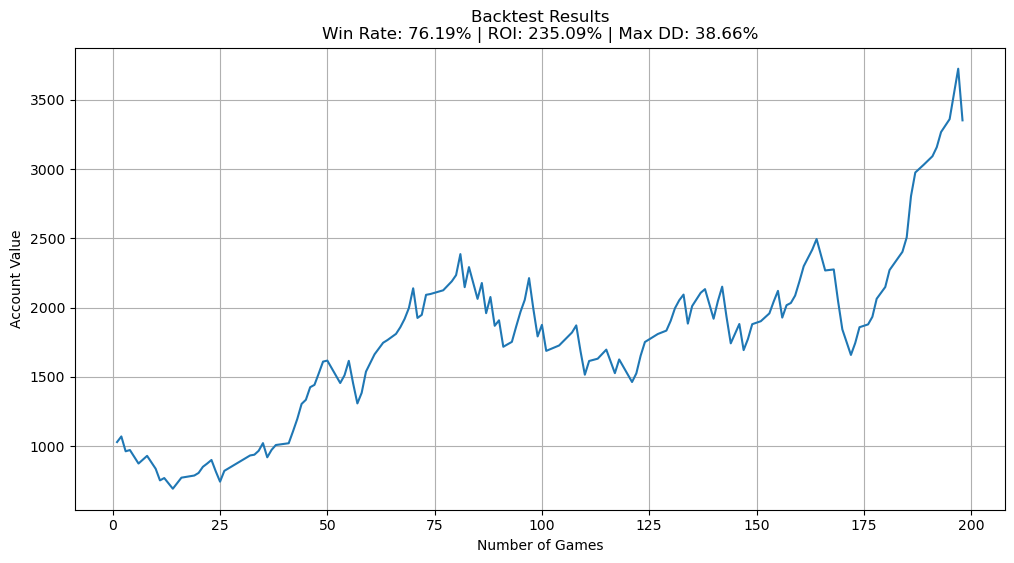

{'final_value': 3350.9208786503746,
 'roi': 2.3509208786503746,
 'win_rate': 0.7619047619047619,
 'max_drawdown': 0.3866151453314816,
 'total_bets': 147}

In [27]:
# Make predictions for test data
# model = grid_search.best_estimator_
y_pred = model.predict(perf_conts)

nfl_utils.backtest_model(model, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.1, 
                   confidence_threshold=0.0, show_plot=True, max_won_odds=2.2)

In [ ]:
# Make confusion matrix
cm = confusion_matrix(perf_y_col[:,0], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save XGBoost model

In [ ]:
model.save_model('xgboost_model.bin')